### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import itertools as itertls
import warnings

from tqdm import notebook
from tqdm import tqdm 
from typing import Union

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess

from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            mean_absolute_percentage_error

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})

### Function declarations

In [3]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(12, 4), 
                     use_date_locator=True, title=None, use_scatter=True):
    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(x, y, linestyle="-", marker=".")

    if use_date_locator:
        formatter = mdates.DateFormatter("%d/%m/%Y")
        # locator = mdates.WeekLocator()
        # locator = mdates.YearLocator(base=2)
        locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 3))
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_major_locator(locator)

    ax.grid("on")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if title is not None:
        ax.set_title(title)

    if use_date_locator:
        for j, label in enumerate(ax.get_xticklabels()):
            label.set_rotation(40)
            label.set_horizontalalignment('right')

    plt.show()


### Pre-processing

In [4]:
file_path = "./data/CDB THN 2021-2024.csv"
df_cdb = pd.read_csv(file_path)
df_cdb["Tgl. Mohon"] = pd.to_datetime(df_cdb["Tgl. Mohon"], format="%d/%m/%Y")
df_cdb["Tgl. Lahir"] = pd.to_datetime(df_cdb["Tgl. Lahir"], format="%d/%m/%Y")
df_cdb

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA
...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0


In [5]:
df_cdb_with_initial = df_cdb.copy()
df_cdb_with_initial["initial Varian Plus"] = df_cdb_with_initial["Varian Plus"].apply(lambda x: x[0])
df_cdb_with_initial

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L
...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M


In [6]:
df_cdb_with_tipe = df_cdb_with_initial.copy()

def tipe_customer(row):
    if row[["Gender", "Tgl. Lahir", "Pekerjaan", "Pengeluaran", "Pendidikan"]].isnull().any():
        return "INSTANSI LUAR"
    else:
        return "INDIVIDU"

df_cdb_with_tipe["Tipe Pembeli"] = df_cdb_with_tipe.apply(tipe_customer, axis=1)
df_cdb_with_tipe["Umur"] = (pd.to_datetime("today") - df_cdb_with_tipe["Tgl. Lahir"]).dt.days // 365

df_cdb_with_tipe

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L,INDIVIDU,28
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L,INDIVIDU,22
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L,INDIVIDU,28
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L,INDIVIDU,42
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L,INDIVIDU,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M,INDIVIDU,20
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M,INDIVIDU,47
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L,INDIVIDU,64
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M,INDIVIDU,45


### Plot kumulatif

Take initial varian plus "H"

In [7]:
df_H = df_cdb_with_tipe[df_cdb_with_tipe["initial Varian Plus"] == "H"].copy()
df_H

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
12,2021-01-05,JULI HARJANTO,JL BLORA,KLANDASAN ILIR,BALIKPAPAN KOTA,LAKI-LAKI,1977-07-18,Pegawai Swasta-Jasa,"< Rp. 900.000,-",SLTA/SMU,HZ3,H,INDIVIDU,47
13,2021-01-06,"DHINA R. AGUSTIANA DA, SE",JL MASJID AR RAUDAH I,GUNUNG BAHAGIA,BALIKPAPAN SELATAN,PEREMPUAN,1974-08-13,IBU RUMAH TANGGA,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SARJANA,HWC,H,INDIVIDU,50
24,2021-01-07,AHMAD HABIBI HARAHAP,JL DAKSA TIMUR I,SEPINGGAN,BALIKPAPAN SELATAN,LAKI-LAKI,1995-04-30,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,HDN,H,INDIVIDU,30
31,2021-01-07,GALIH PUTRO WICAKSONO,JL JEND SUDIRMAN ASPOL STAL KUDA,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1993-05-26,TNI/POLRI,"< Rp. 900.000,-",AKADEMI/DIPLOMA,HZ3,H,INDIVIDU,32
37,2021-01-09,VELIANA FEBRIANTI,JL GUNUNG GEMBIRA,BARU ILIR,BALIKPAPAN BARAT,PEREMPUAN,1997-02-25,Pegawai Swasta-Perdagangan,"< Rp. 900.000,-",SLTA/SMU,HS2,H,INDIVIDU,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5956,2024-04-06,ERNIE DIANA NUR,JL. SIDOMULYO,MARGO MULYO,BALIKPAPAN BARAT,PEREMPUAN,1977-08-14,IBU RUMAH TANGGA,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,HDP,H,INDIVIDU,47
6330,2024-06-06,ERNI,JL. WOLTET MONGINSIDI GG. MACAN,BARU ULU,BALIKPAPAN BARAT,PEREMPUAN,1977-07-07,Wiraswasta-Jasa,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,HD7,H,INDIVIDU,47
6351,2024-06-10,ZULFIKAR,JL TELINDUNG,BATU AMPAR,BALIKPAPAN UTARA,LAKI-LAKI,1988-02-07,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,HJ9,H,INDIVIDU,37
6501,2024-07-08,JOSUA,JL JENDRAL SUDIRMAN,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,2000-07-22,Pegawai Swasta-Jasa,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,HDN,H,INDIVIDU,24


Plot data initial varian plus "H"

In [8]:
df_H_count = df_H[["Tgl. Mohon"]].copy()
df_H_count["count"] = 1.
df_H_count = df_H_count.groupby("Tgl. Mohon").agg("count").reset_index()
df_H_count["cumulative_sum"] = df_H_count["count"].cumsum()
df_H_count["rolling_7days"] = df_H_count["count"].rolling(window=7, 
                                min_periods=1).sum()
df_H_count

,Tgl. Mohon,count,cumulative_sum,rolling_7days
0,2021-01-05,1,1,1.0
1,2021-01-06,1,2,2.0
2,2021-01-07,2,4,4.0
3,2021-01-09,1,5,5.0
4,2021-01-11,1,6,6.0
...,...,...,...,...
295,2024-04-06,1,443,7.0
296,2024-06-06,1,444,7.0
297,2024-06-10,1,445,7.0
298,2024-07-08,1,446,7.0


Groub by weekly

In [9]:
df_H_weekly = df_H_count[["Tgl. Mohon"]].copy()
df_H_count["Tgl. Mohon"] = pd.to_datetime(df_H_count["Tgl. Mohon"])

df_H_weekly = (df_H.resample("W-MON", on="Tgl. Mohon").size()
                .reset_index(name="count"))

df_H_weekly["cumulative_sum"] = df_H_weekly["count"].cumsum()
df_H_weekly


,Tgl. Mohon,count,cumulative_sum
0,2021-01-11,6,6
1,2021-01-18,7,13
2,2021-01-25,8,21
3,2021-02-01,9,30
4,2021-02-08,4,34
...,...,...,...
182,2024-07-08,1,446
183,2024-07-15,0,446
184,2024-07-22,0,446
185,2024-07-29,0,446


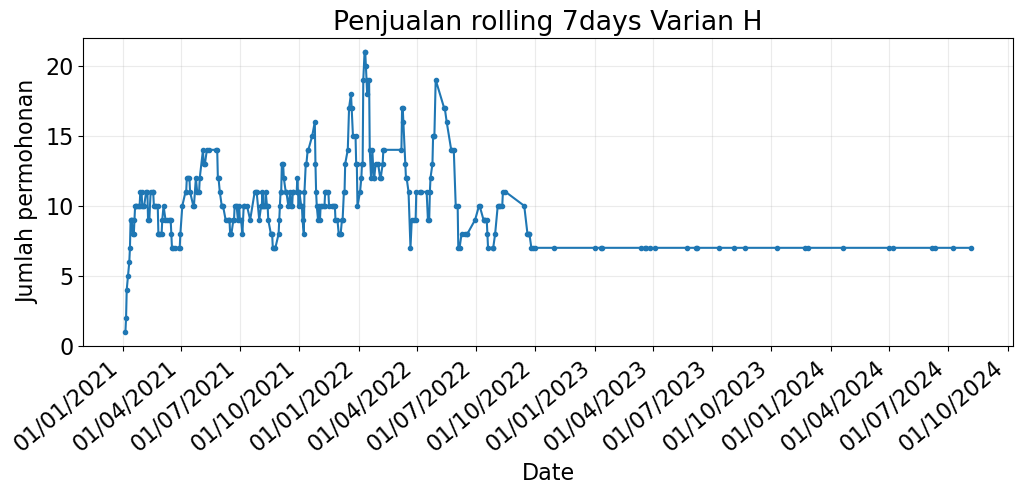

In [10]:
plot_time_series(df_H_count["Tgl. Mohon"], df_H_count["rolling_7days"], 
                title="Penjualan rolling 7days Varian H",
                xlabel="Date", ylabel="Jumlah permohonan")

In [11]:
Q1 = df_H_count["rolling_7days"].quantile(0.25)
Q3 = df_H_count["rolling_7days"].quantile(0.75)
IQR = Q3 - Q1

batas_bawah = Q1 - 1.5 * IQR
batas_atas = Q3 + 1.5 * IQR

# Deteksi dan tampilkan outlier
outliers = df_H_count[(df_H_count["rolling_7days"] < batas_bawah) | 
                      (df_H_count["rolling_7days"] > batas_atas)]
print(f"Jumlah outlier (rolling_7days) varian H: {len(outliers)}")
display(outliers)


Jumlah outlier (rolling_7days) varian H: 17


,Tgl. Mohon,count,cumulative_sum,rolling_7days
0,2021-01-05,1,1,1.0
1,2021-01-06,1,2,2.0
179,2021-12-17,4,265,17.0
180,2021-12-20,3,268,18.0
181,2021-12-21,1,269,17.0
191,2022-01-08,7,291,19.0
192,2022-01-10,4,295,21.0
193,2022-01-11,1,296,21.0
194,2022-01-12,3,299,20.0
195,2022-01-13,1,300,19.0


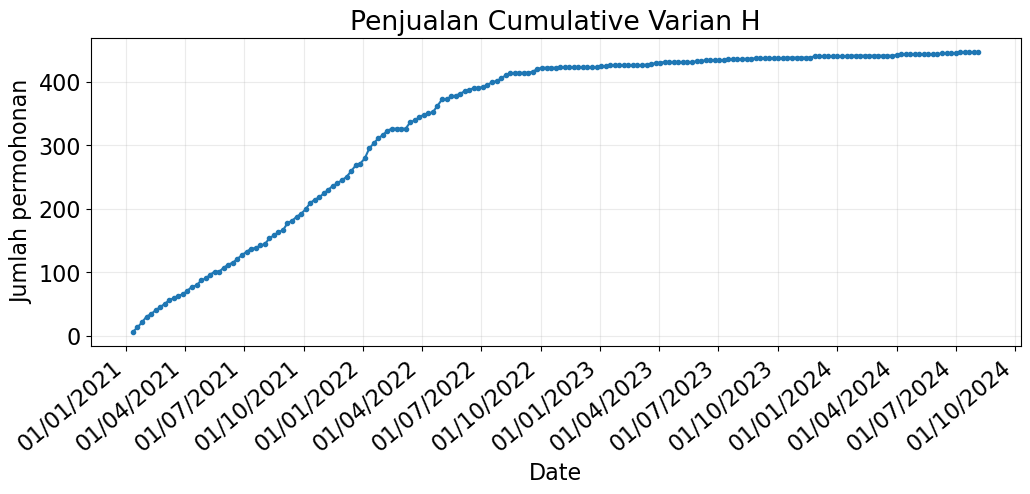

In [149]:
plot_time_series(df_H_weekly["Tgl. Mohon"], df_H_weekly["cumulative_sum"], 
                title="Penjualan Cumulative Varian H",
                xlabel="Date", ylabel="Jumlah permohonan")

#### weekly

In [150]:
ADF_result = adfuller(df_H_weekly["cumulative_sum"])
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -2.7844259742611865
p-value: 0.06053307410871535


first diff (_d_=1)

In [151]:
H_diff = np.diff(df_H_weekly["cumulative_sum"], n=1)
ADF_result = adfuller(H_diff)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -2.218979090316571
p-value: 0.19942939068380056


sec diff (_d_=2)

In [152]:
H_diff2 = np.diff(H_diff, n=1)
ADF_result2 = adfuller(H_diff2)
print(f"ADF statistic : {ADF_result2[0]}")
print(f"p-value : {ADF_result2[1]}")


ADF statistic : -6.577661944444589
p-value : 7.653176391424563e-09


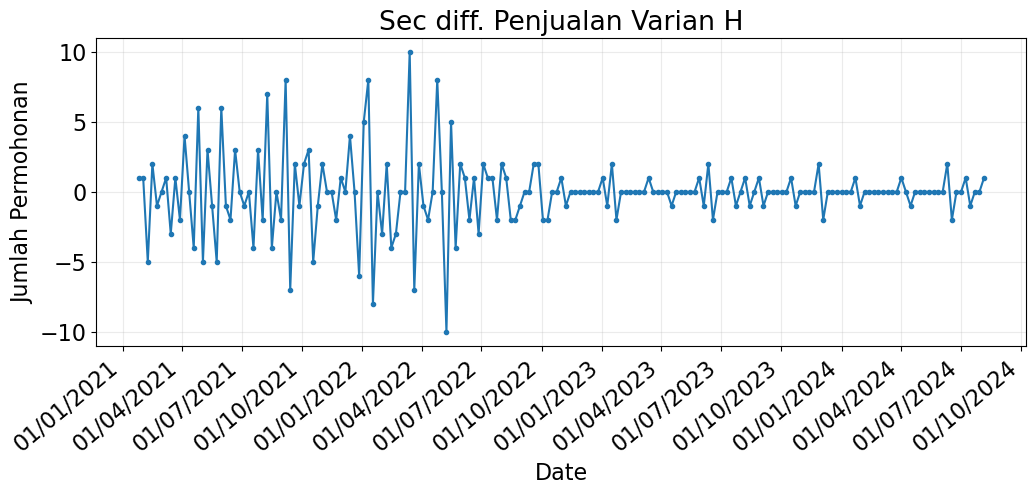

In [153]:
plot_time_series(df_H_weekly["Tgl. Mohon"].iloc[2:], H_diff2, 
                 title="Sec diff. Penjualan Varian H",
                 xlabel="Date", ylabel="Jumlah Permohonan")

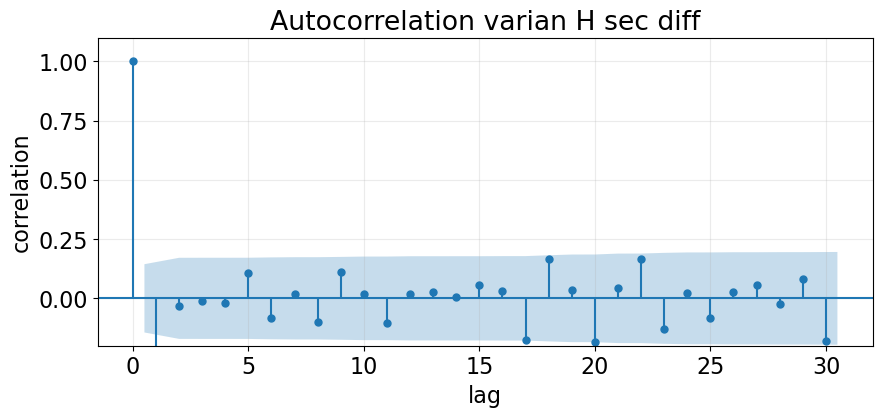

In [154]:
fig, ax = plt.subplots(figsize=(10, 4))

fig = plot_acf(H_diff2, lags=30, ax=ax)

ax.set_ylim([-.2, 1.1])
ax.set_ylabel("correlation")
ax.set_xlabel("lag")
ax.set_title("Autocorrelation varian H sec diff")
ax.grid("on")

plt.show(fig)

### harian

In [155]:
ADF_result = adfuller(df_H_count["rolling_7days"])
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -2.039299087605271
p-value: 0.2696119606739832


fisrt diff (_d_=1)

In [156]:
H_diff = np.diff(df_H_count["rolling_7days"], n=1)
ADF_result = adfuller(H_diff)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -7.041548683404132
p-value: 5.829201451034623e-10


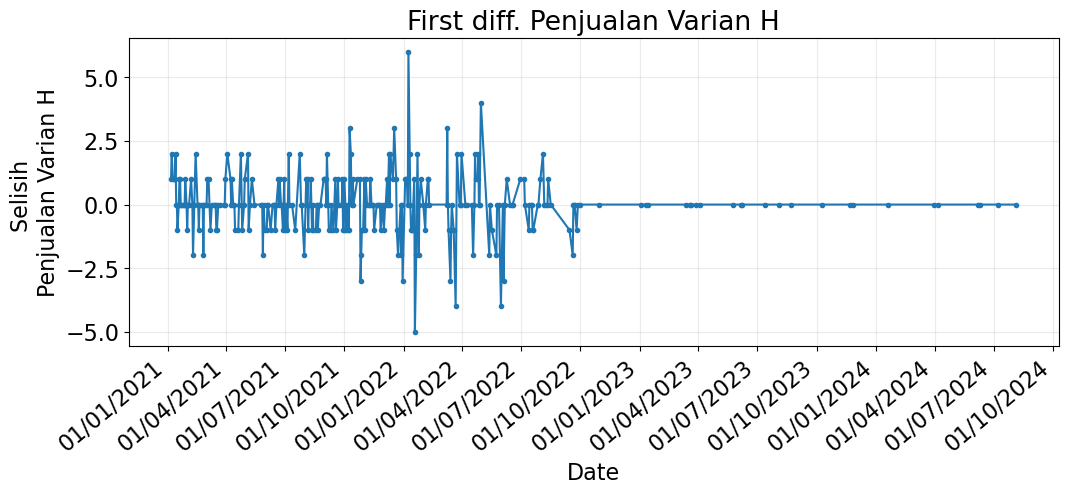

In [157]:
plot_time_series(df_H_count["Tgl. Mohon"].iloc[1:], H_diff, 
                 title="First diff. Penjualan Varian H",
                 xlabel="Date", ylabel="Selisih \nPenjualan Varian H")

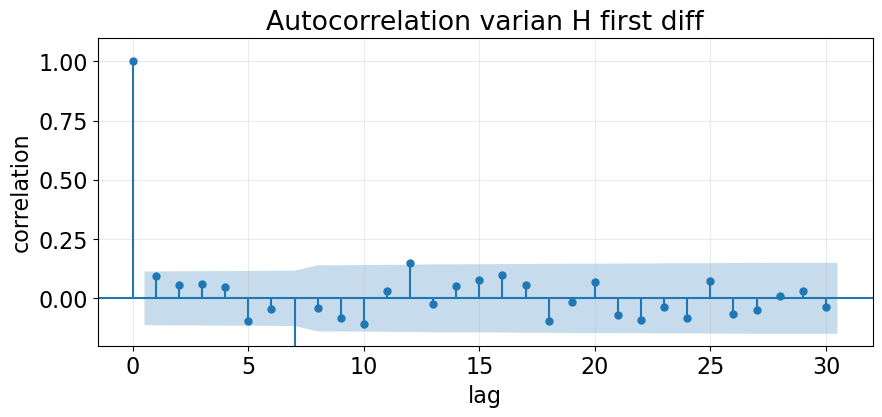

In [158]:
fig, ax = plt.subplots(figsize=(10, 4))

fig = plot_acf(H_diff, lags=30, ax=ax)

ax.set_ylim([-.2, 1.1])
ax.set_ylabel("correlation")
ax.set_xlabel("lag")
ax.set_title("Autocorrelation varian H first diff")
ax.grid("on")

plt.show(fig)

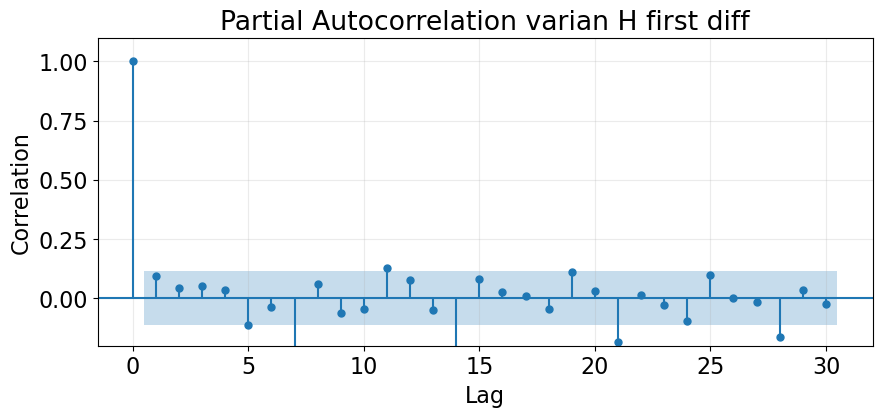

In [159]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_pacf(H_diff, lags=30, ax=ax)

ax.set_ylim([-0.2, 1.1])
ax.set_ylabel("Correlation")
ax.set_xlabel("Lag")
ax.set_title("Partial Autocorrelation varian H first diff")
ax.grid("on")

plt.show()

gaada lag yang signifikan pada acf dan pacf = random walk

In [160]:
# --- Buat DataFrame baru untuk proses modeling --- #
df_model_H = df_H_count.copy().reset_index(drop=True)

# Buat kolom H_diff secara manual (dari np.diff)
df_model_H = df_model_H.iloc[1:].copy()  # karena np.diff mengurangi 1 baris
df_model_H["H_diff"] = H_diff

### Data Splitting

In [161]:
split_idx = int(len(df_model_H) * 0.8)
df_train = df_model_H.iloc[:split_idx].copy()
df_test = df_model_H.iloc[split_idx:].copy()
df_train_extended = pd.concat([df_train, df_test.iloc[:1]])

print(f"(len(df_train), len(df_test)): {len(df_train), len(df_test)}")


(len(df_train), len(df_test)): (239, 60)


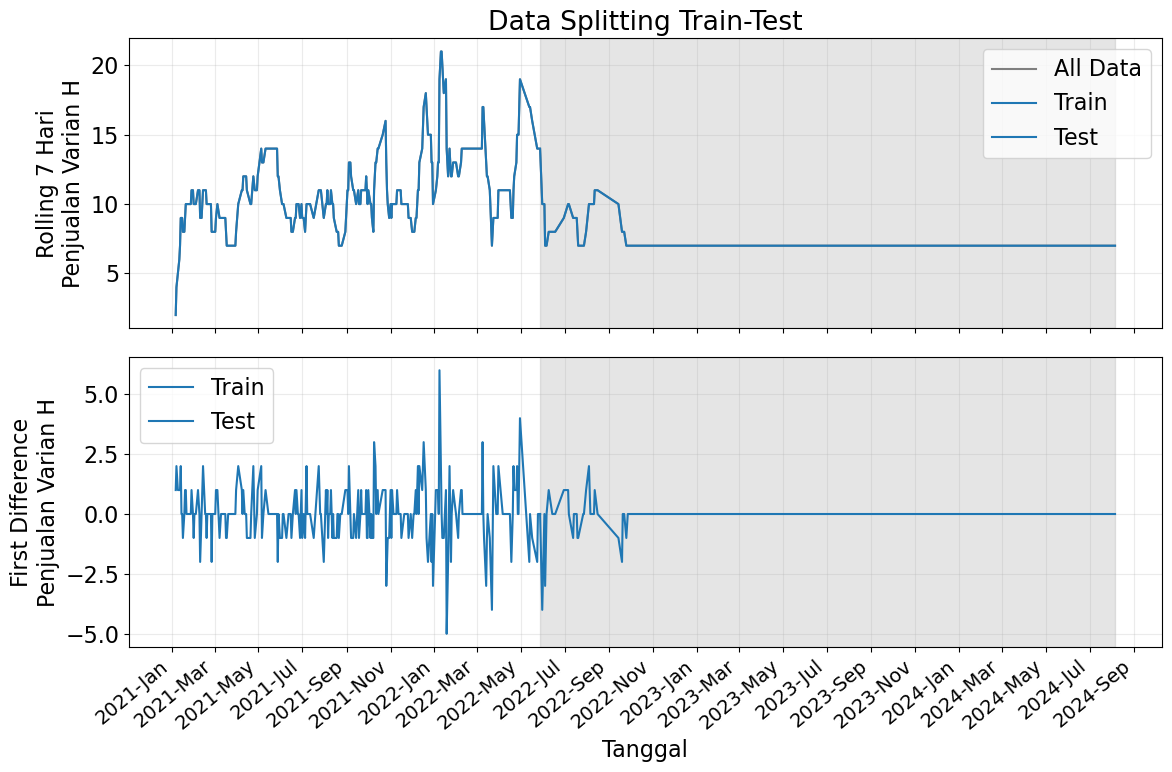

In [162]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 8))

# --- First Row: rolling_7days
axes[0].plot(df_model_H["Tgl. Mohon"], df_model_H["rolling_7days"], label="All Data", color="tab:gray")
axes[0].plot(df_train["Tgl. Mohon"], df_train["rolling_7days"], label="Train", color="tab:blue")
axes[0].plot(df_test["Tgl. Mohon"], df_test["rolling_7days"], label="Test", color="tab:blue")
axes[0].set_ylabel("Rolling 7 Hari\nPenjualan Varian H")
axes[0].set_title("Data Splitting Train-Test")
axes[0].legend()
axes[0].grid("on")

# Format tanggal
formatter = mdates.DateFormatter("%Y-%b")
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

# --- Second Row: H_diff
axes[1].plot(df_train_extended["Tgl. Mohon"], df_train_extended["H_diff"], label="Train", color="tab:blue")
axes[1].plot(df_test["Tgl. Mohon"], df_test["H_diff"], label="Test", color="tab:blue")
axes[1].set_xlabel("Tanggal")
axes[1].set_ylabel("First Difference\nPenjualan Varian H")
axes[1].legend()
axes[1].grid("on")

# Highlight test area
for j in range(2):
    axes[j].axvspan(df_test["Tgl. Mohon"].iloc[0], df_test["Tgl. Mohon"].iloc[-1], 
                    color="gray", alpha=0.2, label="Forecast Area" if j == 0 else None)

# Rotate x-axis labels
for label in axes[1].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment("right")
    label.set_fontsize(14)

plt.tight_layout()
plt.show()


C:\Users\TEMP\AppData\Local\Temp\ipykernel_8796\2444944828.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


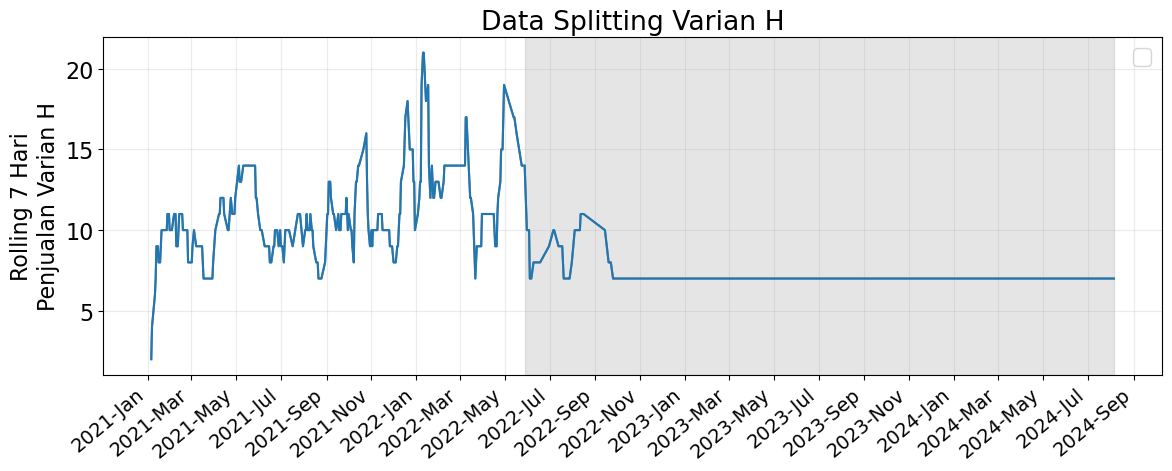

In [170]:
fig, ax = plt.subplots(figsize=(12, 5))

# --- Plot Rolling 7 Hari
ax.plot(df_model_H["Tgl. Mohon"], df_model_H["rolling_7days"], color="tab:gray")
ax.plot(df_train["Tgl. Mohon"], df_train["rolling_7days"], color="tab:blue")
ax.plot(df_test["Tgl. Mohon"], df_test["rolling_7days"], color="tab:blue")
ax.set_ylabel("Rolling 7 Hari\nPenjualan Varian H")
# ax.set_xlabel("Date")
ax.set_title("Data Splitting Varian H")
ax.legend()
ax.grid("on")

# Highlight test area
ax.axvspan(df_test["Tgl. Mohon"].iloc[0], df_test["Tgl. Mohon"].iloc[-1], 
           color="gray", alpha=0.2, label="Forecast Area")

# Format tanggal
formatter = mdates.DateFormatter("%Y-%b")
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

# Rotate x-axis labels
for label in ax.get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment("right")
    label.set_fontsize(14)

plt.tight_layout()
plt.show()


### Random Walk

Metode $\text{Drift}$ digunakan dalam _time series forecast_ dengan asumsi bahwa perubahan dari waktu ke waktu mengikuti tren linear. Metode ini untuk menangkap tren linier dalam data dan memberikan prediksi yang lebih baik dibandingkan metode rata-rata atau nilai terakhir ketika terdapat pola pertumbuhan atau penurunan yang konsisten. Berikut rumusnya:

$$
  \text{forecast} = \text{drift} \times \text{timestep} + y_i
$$

Keterangan:
- $ y_i $ adalah nilai awal
- $\text{drift}$ menunjukkan perubahan rata-rata per langkah waktu.

Drift dihitung sebagai kemiringan garis yang menghubungkan nilai awal $ y_i $ dengan nilai terakhir dalam data pelatihan $ y_f $:

$$
  \text{drift} = \text{slope} = \frac{h_y}{h_x} = \frac{y_f - y_i}{\text{\# timesteps} - 1}
$$

Dengan:
- $ h_y = y_f - y_i $ sebagai perubahan nilai antara titik awal dan titik akhir.
- $ h_x = \text{timesteps} - 1 $ sebagai selang waktu antara dua titik tersebut.

In [163]:
# --- Mean Forecast --- #
mean_train = np.mean(df_train["rolling_7days"])
df_test["pred_mean"] = mean_train

df_test.head()

,Tgl. Mohon,count,cumulative_sum,rolling_7days,H_diff,pred_mean
240,2022-05-28,1,381,14.0,0.0,10.983264
241,2022-05-31,1,382,10.0,-4.0,10.983264
242,2022-06-03,1,383,10.0,0.0,10.983264
243,2022-06-04,1,384,7.0,-3.0,10.983264
244,2022-06-06,1,385,7.0,0.0,10.983264


In [164]:
# --- Last Value Forecast --- #
last_value = df_train["rolling_7days"].iloc[-1]
df_test["pred_last"] = last_value

df_test.head()

,Tgl. Mohon,count,cumulative_sum,rolling_7days,H_diff,pred_mean,pred_last
240,2022-05-28,1,381,14.0,0.0,10.983264,14.0
241,2022-05-31,1,382,10.0,-4.0,10.983264,14.0
242,2022-06-03,1,383,10.0,0.0,10.983264,14.0
243,2022-06-04,1,384,7.0,-3.0,10.983264,14.0
244,2022-06-06,1,385,7.0,0.0,10.983264,14.0


In [165]:
# --- DRIFT Forecast --- #
y_i = df_train["H_diff"].iloc[0]
y_f = df_train["H_diff"].iloc[-1]
n_train = len(df_train)

drift = (y_f - y_i) / (n_train - 1)
print(f"Drift : {drift:}")

Drift : -0.004201680672268907


In [166]:
n_test = len(df_test)
pred_drift = [drift * t + y_i for t in range(1, n_test + 1)]
df_test["pred_drift"] = pred_drift

df_test.head()

,Tgl. Mohon,count,cumulative_sum,rolling_7days,H_diff,pred_mean,pred_last,pred_drift
240,2022-05-28,1,381,14.0,0.0,10.983264,14.0,0.995798
241,2022-05-31,1,382,10.0,-4.0,10.983264,14.0,0.991597
242,2022-06-03,1,383,10.0,0.0,10.983264,14.0,0.987395
243,2022-06-04,1,384,7.0,-3.0,10.983264,14.0,0.983193
244,2022-06-06,1,385,7.0,0.0,10.983264,14.0,0.978992


In [167]:
# Inverse differencing ke rolling_7days
last_rolling_train = df_train["rolling_7days"].iloc[-1]
pred_drift_rolling = [last_rolling_train + sum(pred_drift[:i+1]) for i in range(n_test)]
df_test["pred_drift_rolling"] = pred_drift_rolling

# --- Evaluation --- #
true_rolling = df_test["rolling_7days"].values

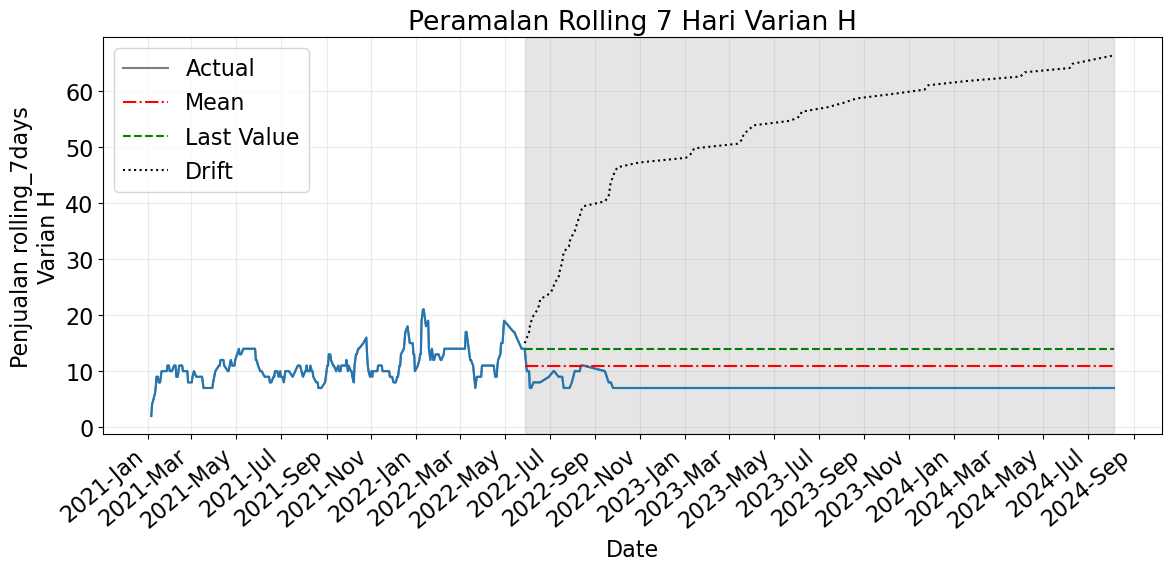

In [172]:
# Visualisasi hasil forecast
fig, ax = plt.subplots(figsize=(12, 6))

# --- Data aktual
ax.plot(df_model_H["Tgl. Mohon"], df_model_H["rolling_7days"], color="tab:gray", label="Actual")
ax.plot(df_train["Tgl. Mohon"], df_train["rolling_7days"], color="tab:blue")
ax.plot(df_test["Tgl. Mohon"], df_test["rolling_7days"], color="tab:blue")

# --- Hasil Forecast
ax.plot(df_test["Tgl. Mohon"], df_test["pred_mean"], "r-.", label="Mean")
ax.plot(df_test["Tgl. Mohon"], df_test["pred_last"], "g--", label="Last Value")
ax.plot(df_test["Tgl. Mohon"], df_test["pred_drift_rolling"], "k:", label="Drift")

# --- Highlight test/forecast area
ax.axvspan(df_test["Tgl. Mohon"].iloc[0], df_test["Tgl. Mohon"].iloc[-1], color="gray", alpha=0.2)

# --- Format sumbu tanggal
formatter = mdates.DateFormatter("%Y-%b")
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

# --- Format sumbu dan label
ax.set_xlabel("Date")
ax.set_ylabel("Penjualan rolling_7days\nVarian H")
ax.set_title("Peramalan Rolling 7 Hari Varian H")
ax.legend()
ax.grid(True)

# --- Rotate tanggal agar mudah dibaca
for label in ax.get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment("right")
    # label.set_fontsize(12)

plt.tight_layout()
plt.show()


### Evaluasi

MAE

In [173]:
mae_pred_mean   = mean_absolute_error(true_rolling, df_test["pred_mean"])
mae_pred_last   = mean_absolute_error(true_rolling, df_test["pred_last"])
mae_pred_drift  = mean_absolute_error(true_rolling, df_test["pred_drift_rolling"])

print(f"MAE mean: {mae_pred_mean}")
print(f"MAE last: {mae_pred_last}")
print(f"MAE drif: {mae_pred_drift}")

MAE mean: 3.0516039051603903
MAE last: 5.966666666666667
MAE drif: 33.818207282913164


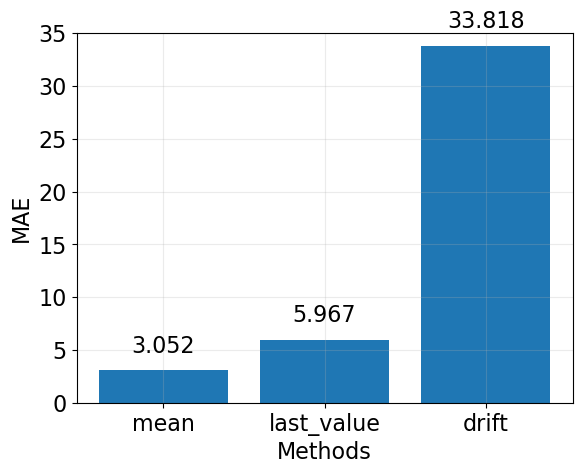

In [174]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [mae_pred_mean, mae_pred_last, mae_pred_drift]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAE")
ax.set_ylim([0, 35])

for idx, val in enumerate(y_array):
  ax.text(idx, val + (max(y_array) * 0.05), s=f"{val:.3f}", ha="center")

plt.show(fig)

In [175]:
mse_pred_mean  = mean_squared_error(true_rolling, df_test["pred_mean"])
mse_pred_last  = mean_squared_error(true_rolling, df_test["pred_last"])
mse_pred_drift = mean_squared_error(true_rolling, df_test["pred_drift_rolling"])

print(f"MSE mean: {mse_pred_mean}")
print(f"MSE last: {mse_pred_last}")
print(f"MSE drif: {mse_pred_drift}")

MSE mean: 10.834310790544048
MSE last: 37.733333333333334
MSE drif: 1399.00187192524


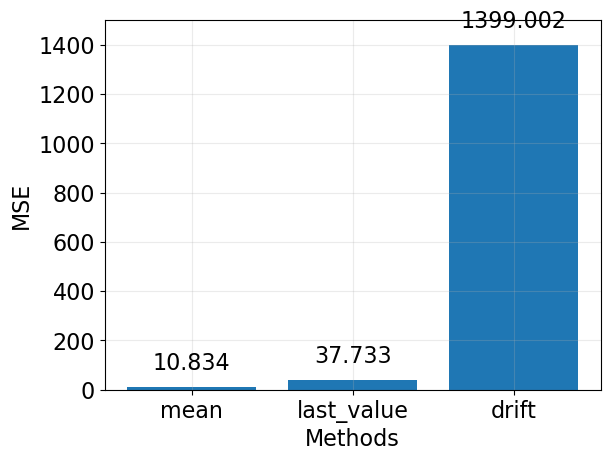

In [176]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [mse_pred_mean, mse_pred_last, mse_pred_drift]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim([0, 1500])

for idx, val in enumerate(y_array):
  ax.text(idx, val + (max(y_array) * 0.05), s=f"{val:.3f}", ha="center")

plt.show(fig)

RMSE

In [177]:
rmse_pred_mean  = np.sqrt(mse_pred_mean)
rmse_pred_last  = np.sqrt(mse_pred_last)
rmse_pred_drift = np.sqrt(mse_pred_drift)

print(f"RMSE mean: {rmse_pred_mean}")
print(f"RMSE last: {rmse_pred_last}")
print(f"RMSE drif: {rmse_pred_drift}")

RMSE mean: 3.291551426082243
RMSE last: 6.142746399887703
RMSE drif: 37.40323344211353


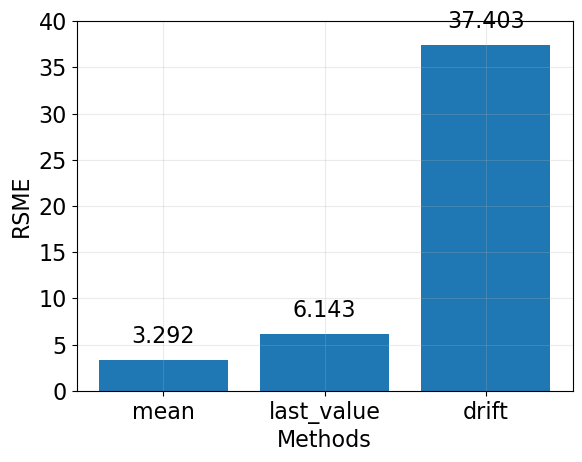

In [178]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [rmse_pred_mean, rmse_pred_last, rmse_pred_drift]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("RSME")
ax.set_ylim([0, 40])

for idx, val in enumerate(y_array):
  ax.text(idx, val + (max(y_array) * 0.05), s=f"{val:.3f}", ha="center")

plt.show(fig)

In [179]:
mape_pred_mean  = mean_absolute_percentage_error(true_rolling, df_test["pred_mean"]) * 100
mape_pred_last  = mean_absolute_percentage_error(true_rolling, df_test["pred_last"]) * 100
mape_pred_drift = mean_absolute_percentage_error(true_rolling, df_test["pred_drift_rolling"]) * 100

print(f"MAPE mean: {mape_pred_mean:5.2f}%")
print(f"MAPE last: {mape_pred_last:5.2f}%")
print(f"MAPE drift: {mape_pred_drift:5.2f}%")

MAPE mean: 41.19%
MAPE last: 79.04%
MAPE drift: 453.44%


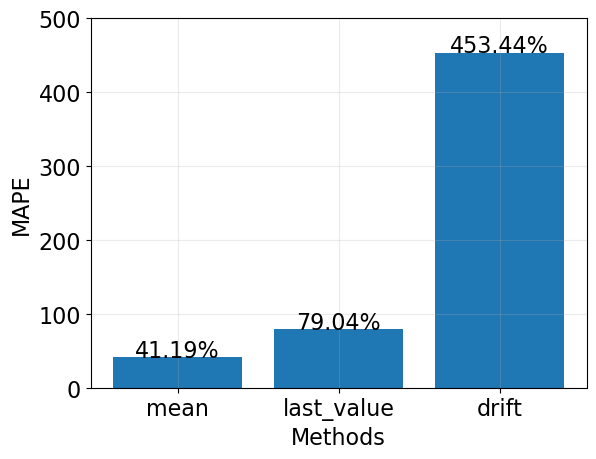

In [180]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [mape_pred_mean, mape_pred_last, mape_pred_drift]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAPE")
ax.set_ylim([0, 500])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}%", ha="center")

plt.show(fig)

MASE

In [181]:
naive = np.abs(np.diff(df_train["rolling_7days"])).mean()
mase_pred_mean  = mae_pred_mean / naive
mase_pred_last  = mae_pred_last / naive
mase_pred_drift = mae_pred_drift / naive

print(f"MASE mean: {mase_pred_mean}")
print(f"MASE last: {mase_pred_last}")
print(f"MASE drift: {mase_pred_drift}")

MASE mean: 3.822535418043015
MASE last: 7.474035087719298
MASE drift: 42.36175438596491


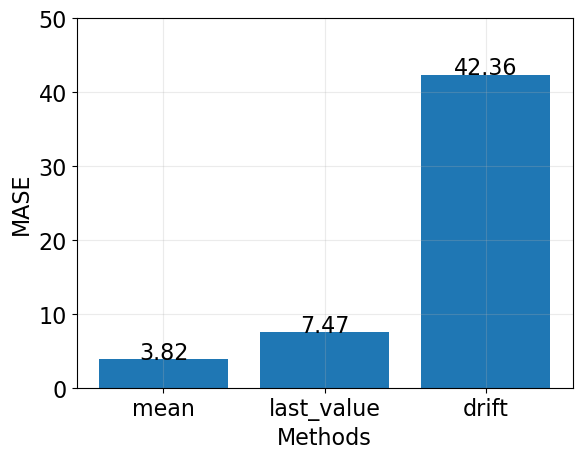

In [182]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [mase_pred_mean, mase_pred_last, mase_pred_drift]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MASE")
ax.set_ylim([0, 50])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.1, s=f"{val:.2f}", ha="center")

plt.show(fig)

gaada lag yang signifikan pada acf dan pacf = random walk

### Data Splitting

In [183]:
min_length = min(len(df_H_count["Tgl. Mohon"].iloc[1:]), len(H_diff))

df_H_diff = pd.DataFrame({
    "Tgl. Mohon": df_H_count["Tgl. Mohon"].iloc[1:min_length+1].values,
    "H_diff": H_diff[:min_length]
})

split_idx = int(0.8 * len(df_H_diff))
df_train = df_H_diff.iloc[:split_idx].copy()
df_test = df_H_diff.iloc[split_idx:].copy()

print(f"(len(df_train), len(df_test)): {len(df_train), len(df_test)}")

(len(df_train), len(df_test)): (239, 60)


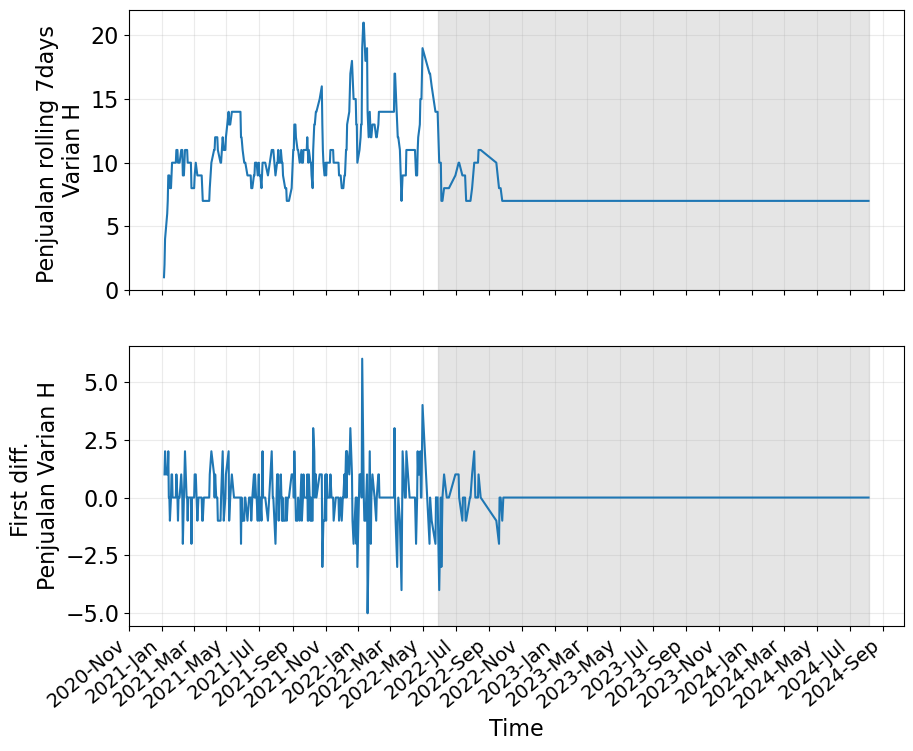

In [184]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

# -- first row
axes[0].plot(df_H_count["Tgl. Mohon"], df_H_count["rolling_7days"])
axes[0].grid("on")
axes[0].set_ylabel("Penjualan rolling 7days \nVarian H")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

# -- second row
axes[1].plot(df_train["Tgl. Mohon"], df_train["H_diff"])
axes[1].plot(df_test["Tgl. Mohon"], df_test["H_diff"], color="tab:blue")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("First diff. \nPenjualan Varian H")
axes[1].grid("on")

# add forecast area
for j in range(2):
  axes[j].axvspan(df_test["Tgl. Mohon"].iloc[0], df_test["Tgl. Mohon"].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  label.set_size(14)
  label.set_horizontalalignment('right')

plt.show(fig)

### Random Walk

Metode $\text{Drift}$ digunakan dalam _time series forecast_ dengan asumsi bahwa perubahan dari waktu ke waktu mengikuti tren linear. Metode ini untuk menangkap tren linier dalam data dan memberikan prediksi yang lebih baik dibandingkan metode rata-rata atau nilai terakhir ketika terdapat pola pertumbuhan atau penurunan yang konsisten. Berikut rumusnya:

$$
  \text{forecast} = \text{drift} \times \text{timestep} + y_i
$$

Keterangan:
- $ y_i $ adalah nilai awal
- $\text{drift}$ menunjukkan perubahan rata-rata per langkah waktu.

Drift dihitung sebagai kemiringan garis yang menghubungkan nilai awal $ y_i $ dengan nilai terakhir dalam data pelatihan $ y_f $:

$$
  \text{drift} = \text{slope} = \frac{h_y}{h_x} = \frac{y_f - y_i}{\text{\# timesteps} - 1}
$$

Dengan:
- $ h_y = y_f - y_i $ sebagai perubahan nilai antara titik awal dan titik akhir.
- $ h_x = \text{timesteps} - 1 $ sebagai selang waktu antara dua titik tersebut.

In [185]:
mean_train_random_walk = np.mean(df_train["H_diff"])
df_test["pred_mean"] = mean_train_random_walk

df_test.head()

,Tgl. Mohon,H_diff,pred_mean
239,2022-05-28,0.0,0.054393
240,2022-05-31,-4.0,0.054393
241,2022-06-03,0.0,0.054393
242,2022-06-04,-3.0,0.054393
243,2022-06-06,0.0,0.054393


In [186]:
last_value = df_train.iloc[-1]["H_diff"]
df_test["pred_last"] = last_value

df_test.head()

,Tgl. Mohon,H_diff,pred_mean,pred_last
239,2022-05-28,0.0,0.054393,0.0
240,2022-05-31,-4.0,0.054393,0.0
241,2022-06-03,0.0,0.054393,0.0
242,2022-06-04,-3.0,0.054393,0.0
243,2022-06-06,0.0,0.054393,0.0


In [187]:
y_i = df_train["H_diff"].iloc[0]
y_f = df_train["H_diff"].iloc[-1]
h_y = y_f - y_i
h_x = len(df_train) - 1
drift = h_y / h_x

print(f"drift = {drift}")

drift = -0.004201680672268907


In [188]:
x_vals = np.arange(1, len(df_test) + 1)
df_test["pred_drift"] = drift * x_vals + y_i

df_test.head()

,Tgl. Mohon,H_diff,pred_mean,pred_last,pred_drift
239,2022-05-28,0.0,0.054393,0.0,0.995798
240,2022-05-31,-4.0,0.054393,0.0,0.991597
241,2022-06-03,0.0,0.054393,0.0,0.987395
242,2022-06-04,-3.0,0.054393,0.0,0.983193
243,2022-06-06,0.0,0.054393,0.0,0.978992


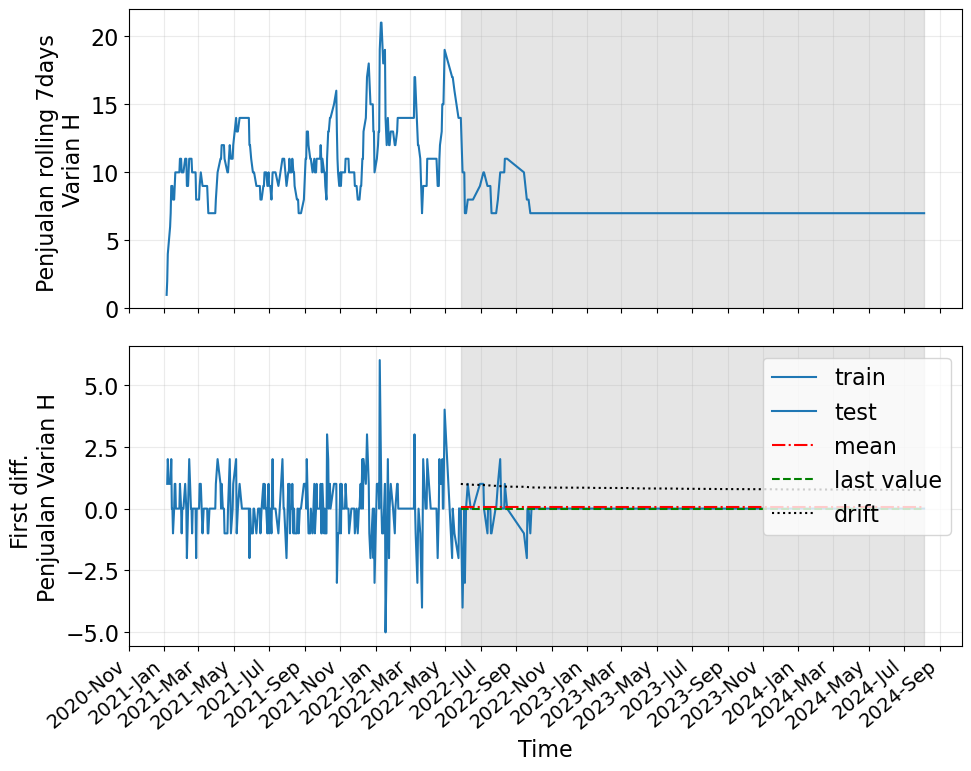

In [189]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

# -- first row: rolling_7days
axes[0].plot(df_H_count["Tgl. Mohon"], df_H_count["rolling_7days"], label="rolling_7days")
axes[0].grid("on")
axes[0].set_ylabel("Penjualan rolling 7days \nVarian H")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

# -- second row: H_diff + predictions
axes[1].plot(df_train["Tgl. Mohon"], df_train["H_diff"], label="train")
axes[1].plot(df_test["Tgl. Mohon"], df_test["H_diff"], color="tab:blue", label="test")
axes[1].plot(df_test["Tgl. Mohon"], df_test["pred_mean"], "r-.", label="mean")
axes[1].plot(df_test["Tgl. Mohon"], df_test["pred_last"], "g--", label="last value")
axes[1].plot(df_test["Tgl. Mohon"], df_test["pred_drift"], "k:", label="drift")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("First diff. \nPenjualan Varian H")
axes[1].grid("on")
axes[1].legend()

# add forecast area
for j in range(2):
    axes[j].axvspan(df_test["Tgl. Mohon"].iloc[0], df_test["Tgl. Mohon"].iloc[-1], 
                    color="#808080", alpha=0.2)

# rotate labels
for j, label in enumerate(axes[1].get_xticklabels()):
    label.set_rotation(40)
    label.set_size(14)
    label.set_horizontalalignment('right')

plt.tight_layout()
plt.show(fig)


In [190]:
# Ambil nilai rolling_7days terakhir dari data latih
last_rolling_train = df_H_count["rolling_7days"].iloc[len(df_train)]

# Tambahkan hasil forecast asli (bukan differencing)
df_test["forecast_mean"]  = last_rolling_train + df_test["pred_mean"].cumsum()
df_test["forecast_last"]  = last_rolling_train + df_test["pred_last"].cumsum()
df_test["forecast_drift"] = last_rolling_train + df_test["pred_drift"].cumsum()

# Gabungkan nilai aktual rolling_7days
df_test = df_test.merge(df_H_count[["Tgl. Mohon", "rolling_7days"]], on="Tgl. Mohon", how="left")


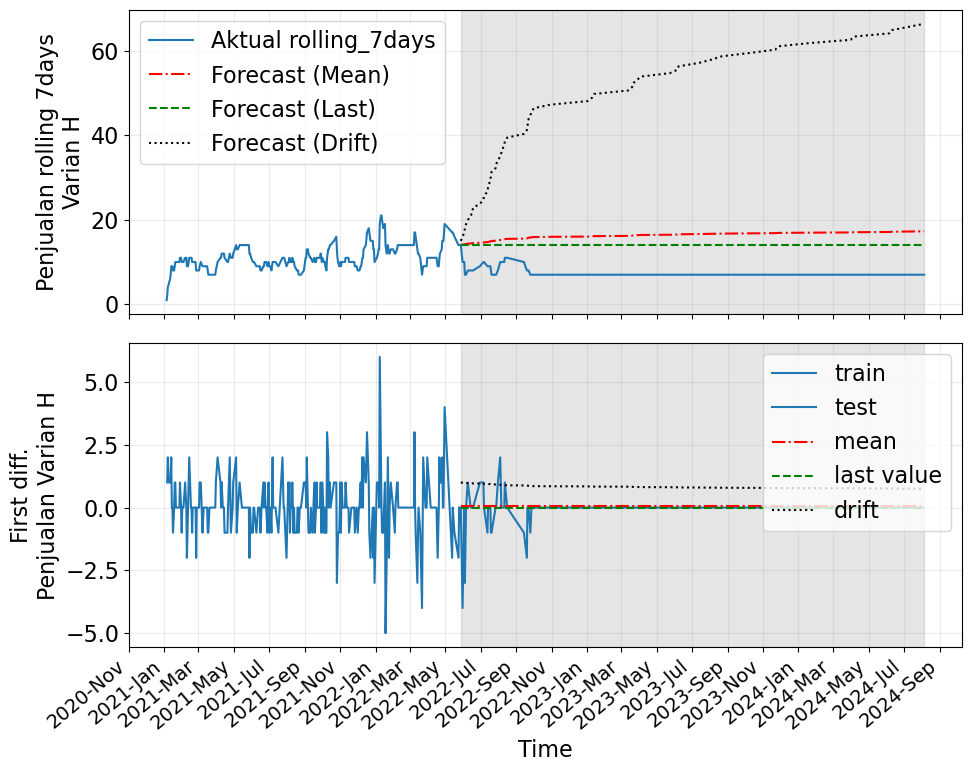

In [191]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

# -- subplot 1: rolling_7days aktual + hasil forecast
axes[0].plot(df_H_count["Tgl. Mohon"], df_H_count["rolling_7days"], label="Aktual rolling_7days")
axes[0].plot(df_test["Tgl. Mohon"], df_test["forecast_mean"], "r-.", label="Forecast (Mean)")
axes[0].plot(df_test["Tgl. Mohon"], df_test["forecast_last"], "g--", label="Forecast (Last)")
axes[0].plot(df_test["Tgl. Mohon"], df_test["forecast_drift"], "k:", label="Forecast (Drift)")
axes[0].set_ylabel("Penjualan rolling 7days\nVarian H")
axes[0].legend()
axes[0].grid(True)

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

# -- subplot 2: H_diff dan prediksi differenced
axes[1].plot(df_train["Tgl. Mohon"], df_train["H_diff"], label="train")
axes[1].plot(df_test["Tgl. Mohon"], df_test["H_diff"], color="tab:blue", label="test")
axes[1].plot(df_test["Tgl. Mohon"], df_test["pred_mean"], "r-.", label="mean")
axes[1].plot(df_test["Tgl. Mohon"], df_test["pred_last"], "g--", label="last value")
axes[1].plot(df_test["Tgl. Mohon"], df_test["pred_drift"], "k:", label="drift")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("First diff.\nPenjualan Varian H")
axes[1].grid(True)
axes[1].legend()

# -- shading area test
for ax in axes:
    ax.axvspan(df_test["Tgl. Mohon"].iloc[0], df_test["Tgl. Mohon"].iloc[-1], 
               color="#808080", alpha=0.2)

# -- format x-axis
for label in axes[1].get_xticklabels():
    label.set_rotation(40)
    label.set_size(14)
    label.set_horizontalalignment('right')

plt.tight_layout()
plt.show()


### Evaluasi

In [192]:
mae_pred_mean  = mean_absolute_error(df_test["rolling_7days"], df_test["forecast_mean"])
mae_pred_last  = mean_absolute_error(df_test["rolling_7days"], df_test["forecast_last"])
mae_pred_drift = mean_absolute_error(df_test["rolling_7days"], df_test["forecast_drift"])

print(f"MAE mean:  {mae_pred_mean:.2f}")
print(f"MAE last:  {mae_pred_last:.2f}")
print(f"MAE drift: {mae_pred_drift:.2f}")

MAE mean:  7.63
MAE last:  5.97
MAE drift: 33.82


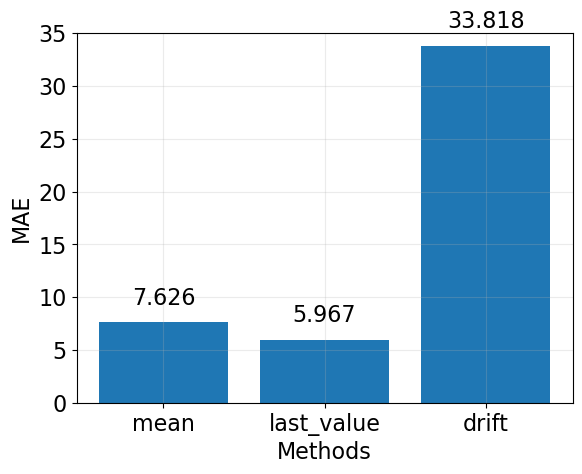

In [193]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [mae_pred_mean, mae_pred_last, mae_pred_drift]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAE")
ax.set_ylim([0, 35])

for idx, val in enumerate(y_array):
  ax.text(idx, val + (max(y_array) * 0.05), s=f"{val:.3f}", ha="center")

plt.show(fig)

In [194]:
mse_pred_mean  = mean_squared_error(df_test["rolling_7days"], df_test["forecast_mean"])
mse_pred_last  = mean_squared_error(df_test["rolling_7days"], df_test["forecast_last"])
mse_pred_drift = mean_squared_error(df_test["rolling_7days"], df_test["forecast_drift"])

print(f"MSE mean:  {mse_pred_mean:.2f}")
print(f"MSE last:  {mse_pred_last:.2f}")
print(f"MSE drift: {mse_pred_drift:.2f}")

MSE mean:  62.79
MSE last:  37.73
MSE drift: 1399.00


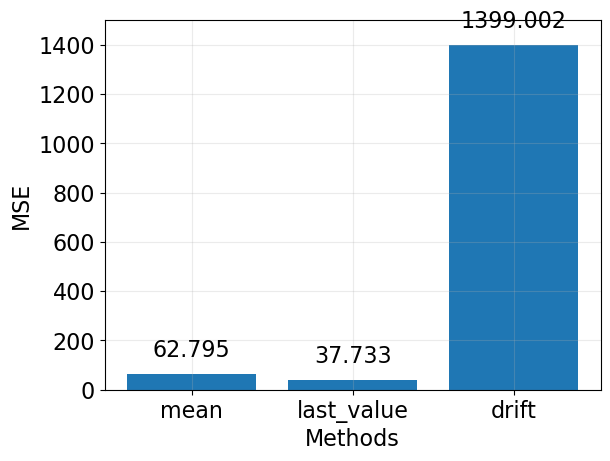

In [195]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [mse_pred_mean, mse_pred_last, mse_pred_drift]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim([0, 1500])

for idx, val in enumerate(y_array):
  ax.text(idx, val + (max(y_array) * 0.05), s=f"{val:.3f}", ha="center")

plt.show(fig)

RMSE

In [196]:
rmse_pred_mean  = np.sqrt(mse_pred_mean)
rmse_pred_last  = np.sqrt(mse_pred_last)
rmse_pred_drift = np.sqrt(mse_pred_drift)

print(f"RMSE mean:  {rmse_pred_mean:.2f}")
print(f"RMSE last:  {rmse_pred_last:.2f}")
print(f"RMSE drift: {rmse_pred_drift:.2f}")

RMSE mean:  7.92
RMSE last:  6.14
RMSE drift: 37.40


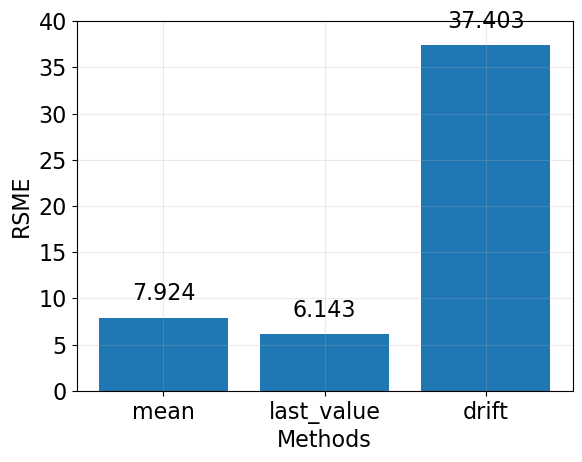

In [197]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [rmse_pred_mean, rmse_pred_last, rmse_pred_drift]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("RSME")
ax.set_ylim([0, 40])

for idx, val in enumerate(y_array):
  ax.text(idx, val + (max(y_array) * 0.05), s=f"{val:.3f}", ha="center")

plt.show(fig)

In [198]:
mape_pred_mean  = mean_absolute_percentage_error(df_test["rolling_7days"], df_test["forecast_mean"]) * 100
mape_pred_last  = mean_absolute_percentage_error(df_test["rolling_7days"], df_test["forecast_last"]) * 100
mape_pred_drift = mean_absolute_percentage_error(df_test["rolling_7days"], df_test["forecast_drift"]) * 100

print(f"MAPE mean:  {mape_pred_mean:.2f}%")
print(f"MAPE last:  {mape_pred_last:.2f}%")
print(f"MAPE drift: {mape_pred_drift:.2f}%")

MAPE mean:  101.40%
MAPE last:  79.04%
MAPE drift: 453.44%


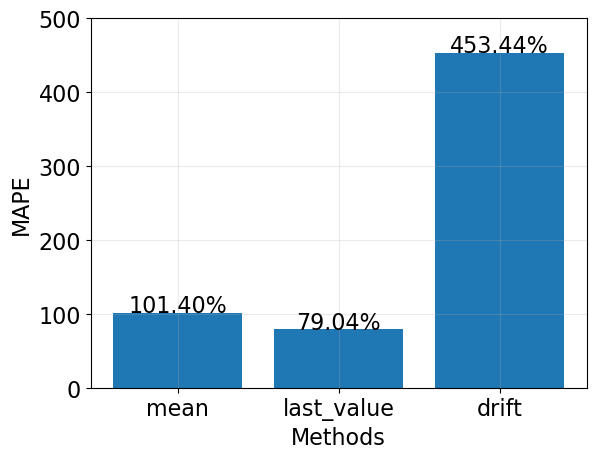

In [199]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [mape_pred_mean, mape_pred_last, mape_pred_drift]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAPE")
ax.set_ylim([0, 500])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}%", ha="center")

plt.show(fig)

MASE

In [200]:
mase_pred_mean  = mae_pred_mean / naive
mase_pred_last  = mae_pred_last / naive
mase_pred_drift = mae_pred_drift / naive

print(f"MASE mean:  {mase_pred_mean:.2f}")
print(f"MASE last:  {mase_pred_last:.2f}")
print(f"MASE drift: {mase_pred_drift:.2f}")

MASE mean:  9.55
MASE last:  7.47
MASE drift: 42.36


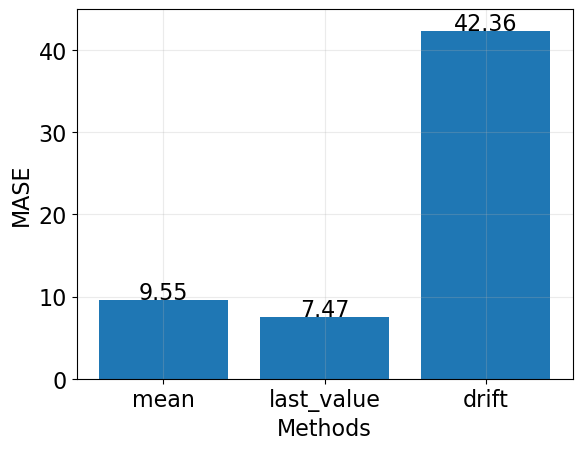

In [201]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [mase_pred_mean, mase_pred_last, mase_pred_drift]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MASE")
ax.set_ylim([0, 45])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.1, s=f"{val:.2f}", ha="center")

plt.show(fig)

### Data Splitting

In [202]:
df_H_diff = pd.DataFrame({
    "Tgl. Mohon": df_H_count["Tgl. Mohon"].iloc[1:],
    "H_diff": H_diff})

split_idx = int(0.8 * len(df_H_diff))
df_train = df_H_diff.iloc[:split_idx].copy()
df_test = df_H_diff.iloc[split_idx:].copy()

print(f"(len(df_train), len(df_test)): {len(df_train), len(df_test)}")

(len(df_train), len(df_test)): (239, 60)


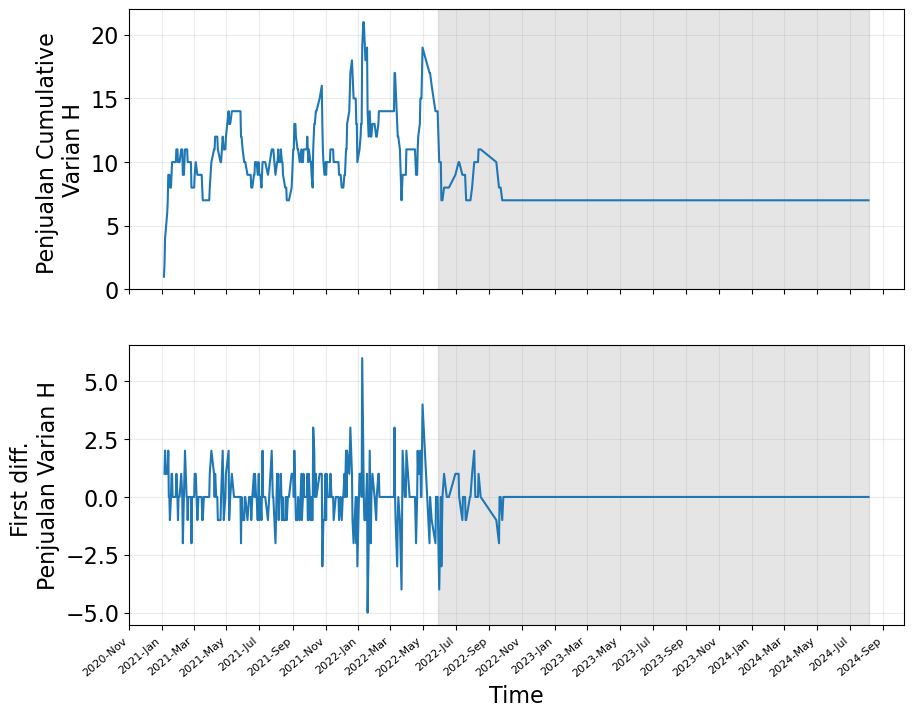

In [203]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

# -- first row
axes[0].plot(df_H_count["Tgl. Mohon"], df_H_count["rolling_7days"])
axes[0].grid("on")
axes[0].set_ylabel("Penjualan Cumulative \nVarian H")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

# -- second row
axes[1].plot(df_train["Tgl. Mohon"], df_train["H_diff"])
axes[1].plot(df_test["Tgl. Mohon"], df_test["H_diff"], color="tab:blue")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("First diff. \nPenjualan Varian H")
axes[1].grid("on")

# add forecast area
for j in range(2):
  axes[j].axvspan(df_test["Tgl. Mohon"].iloc[0], df_test["Tgl. Mohon"].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  label.set_size(8)
  label.set_horizontalalignment('right')

plt.show(fig)

### MA(1) AR(1)

In [204]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, 
                      method: str) -> list:
  """
  The following models using all the dataframe (train + test),
  because we roll out forecast with a correct data with the length
  of forecast is equal to `horizon`
  """
  total_len = train_len + horizon

  if method == "mean":
    pred_mean = []

    for i in range(train_len, total_len, window):
      mean = np.mean(df[:i]["H_diff"])
      pred_mean.extend(mean for _ in range(window))
    # print(len(pred_mean), horizon)
    if len(pred_mean) > horizon:  # cut over counting in (mean for _ in range(window))
      pred_mean = pred_mean[:horizon]

    return pred_mean

  elif method == "last":
    pred_last_value = []

    for i in range(train_len, total_len, window):
      last_value = df[:i]["H_diff"].iloc[-1]
      pred_last_value.extend(last_value for _ in range(window))

    if len(pred_last_value) > horizon:  # cut over counting in (last_value for _ in range(window))
      pred_last_value = pred_last_value[:horizon]

    return pred_last_value

  elif method == "MA":
    pred_MA = []

    for i in range(train_len, total_len, window):
      # model = ARMA(df[:i]["H_diff"], order=(0, 1))
      model = SARIMAX(df[:i]["H_diff"], order=(0, 0, 1))
      res = model.fit(disp=False)
      predictions = res.get_prediction(0, i + window - 1)
      oos_pred = predictions.predicted_mean.iloc[-window:]   # oos: output of sarimax
      pred_MA.extend(oos_pred)

    if len(pred_MA) > horizon:  # cut over counting in (.iloc[-window:])
      pred_MA = pred_MA[:horizon]

    return pred_MA

  elif method == "AR":
    pred_AR = []

    for i in range(train_len, total_len, window):
      model = SARIMAX(df[:i]["H_diff"], order=(1, 0, 0))
      res = model.fit(disp=False)
      predictions = res.get_prediction(0, i + window - 1)
      oos_pred = predictions.predicted_mean.iloc[-window:]   # oos: output of sarimax
      pred_AR.extend(oos_pred)

    return pred_AR

In [205]:
pred_df = df_test.copy()

TRAIN_LEN = len(df_train)
HORIZON = len(df_test)
WINDOW = 6

pred_mean = rolling_forecast(df_H_diff, TRAIN_LEN, HORIZON, WINDOW, "mean")
pred_last_value = rolling_forecast(df_H_diff, TRAIN_LEN, HORIZON, WINDOW, "last")
pred_MA = rolling_forecast(df_H_diff, TRAIN_LEN, HORIZON, WINDOW, "MA")
pred_AR = rolling_forecast(df_H_diff, TRAIN_LEN, HORIZON, WINDOW, "AR")

pred_df["pred_mean"] = pred_mean
pred_df["pred_last_value"] = pred_last_value
pred_df["pred_MA"] = pred_MA
pred_df["pred_AR"] = pred_AR

pred_df

,Tgl. Mohon,H_diff,pred_mean,pred_last_value,pred_MA,pred_AR
240,2022-05-28,0.0,0.054393,0.0,1.410222e-02,-5.467424e-19
241,2022-05-31,-4.0,0.054393,0.0,0.000000e+00,-4.991584e-20
242,2022-06-03,0.0,0.054393,0.0,0.000000e+00,-4.557158e-21
243,2022-06-04,-3.0,0.054393,0.0,0.000000e+00,-4.160540e-22
244,2022-06-06,0.0,0.054393,0.0,0.000000e+00,-3.798441e-23
245,2022-06-09,1.0,0.054393,0.0,0.000000e+00,-3.467856e-24
246,2022-06-14,0.0,0.028571,1.0,7.601243e-02,8.537514e-02
247,2022-06-17,0.0,0.028571,1.0,0.000000e+00,7.288914e-03
248,2022-06-18,0.0,0.028571,1.0,0.000000e+00,6.222920e-04
249,2022-06-30,1.0,0.028571,1.0,0.000000e+00,5.312827e-05


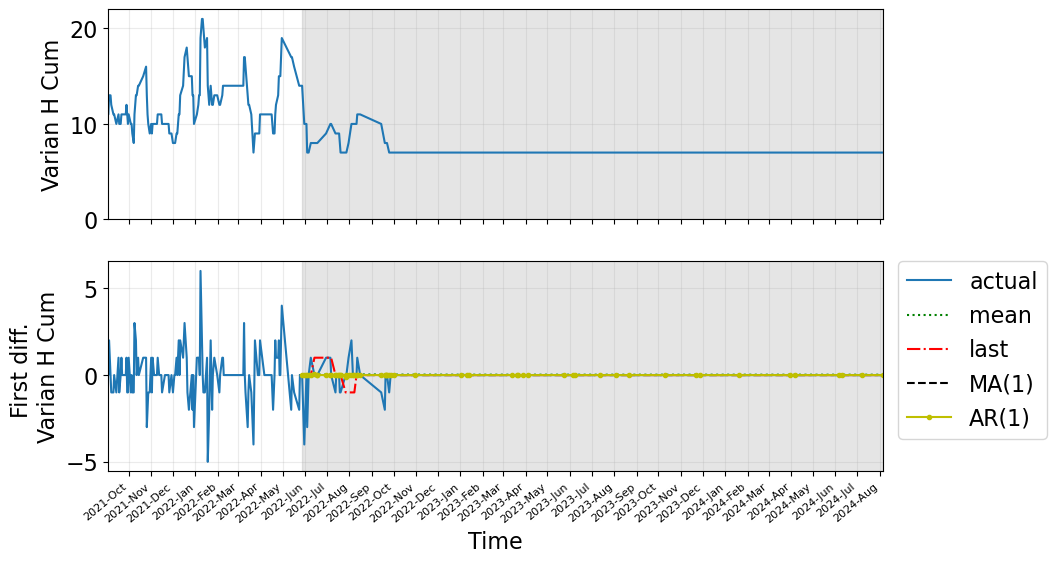

In [206]:
start_idx = 120  # for better visualization
xlim = [df_train["Tgl. Mohon"].iloc[start_idx], df_test["Tgl. Mohon"].iloc[-1]]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 6))


# -- second row
axes[1].plot(df_train["Tgl. Mohon"], df_train["H_diff"])
axes[1].plot(df_test["Tgl. Mohon"], df_test["H_diff"], color="tab:blue", label="actual")

formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

axes[1].set_xlabel("Time")
axes[1].set_ylabel("First diff. \nVarian H Cum")
axes[1].grid("on")

# -- prediction
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_mean"], "g:", label="mean")
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_last_value"], "r-.", label="last")
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_MA"], "k--", label="MA(1)")
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_AR"], "y.-", label="AR(1)")


# add forecast area
for j in range(2):
  axes[j].axvspan(df_test['Tgl. Mohon'].iloc[0], df_test['Tgl. Mohon'].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  label.set_size (8)
  label.set_horizontalalignment('right')

# -- add legend in the second row
axes[1].legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

# -- first row
axes[0].plot(df_H_count['Tgl. Mohon'], df_H_count["rolling_7days"])

axes[0].grid("on")
axes[0].set_ylabel("Varian H Cum")
axes[0].set_xlim(xlim)


plt.show(fig)

In [207]:
mse_mean = mean_squared_error(pred_df["H_diff"], pred_df["pred_mean"])
mse_last = mean_squared_error(pred_df["H_diff"], pred_df["pred_last_value"])
mse_MA = mean_squared_error(pred_df["H_diff"], pred_df["pred_MA"])
mse_AR = mean_squared_error(pred_df["H_diff"], pred_df["pred_AR"])

print(f"MSE mean: {mse_mean}")
print(f"MSE last: {mse_last}")
print(f"MSE MA: {mse_MA}")
print(f"MSE AR: {mse_AR}")

MSE mean: 0.7309645978580289
MSE last: 0.95
MSE MA: 0.7166713502715585
MSE AR: 0.7169494982353257


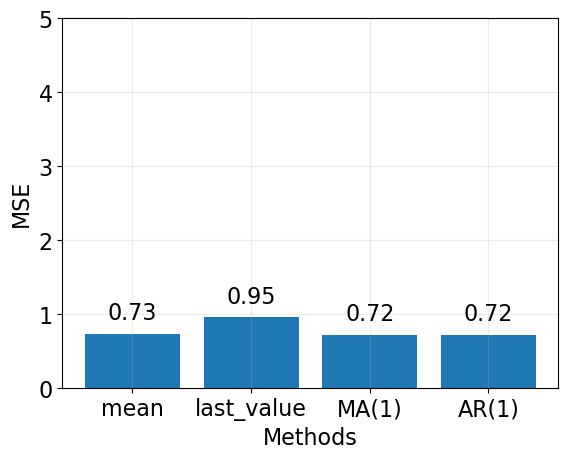

In [208]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)", "AR(1)"]
y_array = [mse_mean, mse_last, mse_MA, mse_AR]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim([0, 5])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

In [209]:
idx_y0 = len(df_train) + 1 
y0 = df_H_count.iloc[idx_y0]["rolling_7days"]
# print(y0)
df_test_H = df_H_count[idx_y0:].copy()
df_test_H["pred_mean"] = y0 + pred_df["pred_mean"].cumsum()
df_test_H["pred_last_value"] = y0 + pred_df["pred_last_value"].cumsum()
df_test_H["pred_MA"] = y0 + pred_df["pred_MA"].cumsum()
df_test_H["pred_AR"] = y0 + pred_df["pred_AR"].cumsum()
df_test_H.head()

,Tgl. Mohon,count,cumulative_sum,rolling_7days,pred_mean,pred_last_value,pred_MA,pred_AR
240,2022-05-28,1,381,14.0,14.054393,14.0,14.014102,14.0
241,2022-05-31,1,382,10.0,14.108787,14.0,14.014102,14.0
242,2022-06-03,1,383,10.0,14.163180,14.0,14.014102,14.0
243,2022-06-04,1,384,7.0,14.217573,14.0,14.014102,14.0
244,2022-06-06,1,385,7.0,14.271967,14.0,14.014102,14.0


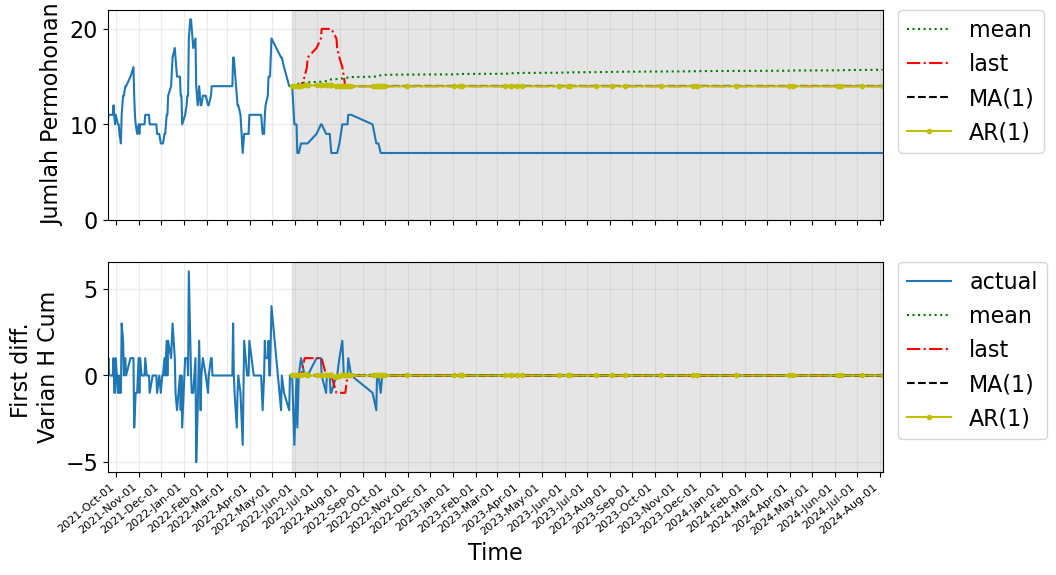

In [210]:
start_idx = 130  # for better visualization
xlim = [df_train["Tgl. Mohon"].iloc[start_idx], df_test["Tgl. Mohon"].iloc[-1]]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 6))

# -- second row
axes[1].plot(df_train["Tgl. Mohon"], df_train["H_diff"])
axes[1].plot(df_test["Tgl. Mohon"], df_test["H_diff"], color="tab:blue", label="actual")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b-%d")
locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
# locator = mdates.DayLocator()
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

axes[1].set_xlabel("Time")
axes[1].set_ylabel("First diff. \nVarian H Cum")
axes[1].grid("on")

# -- prediction
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_mean"], "g:", label="mean")
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_last_value"], "r-.", label="last")
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_MA"], "k--", label="MA(1)")
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_AR"], "y.-", label="AR(1)")


# add forecast area
for j in range(2):
  axes[j].axvspan(df_test['Tgl. Mohon'].iloc[0], df_test['Tgl. Mohon'].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  label.set_size(8)
  label.set_horizontalalignment('right')

# -- add legend in the second row
axes[1].legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

# -- first row
axes[0].plot(df_H_count['Tgl. Mohon'], df_H_count["rolling_7days"])

# -- prediction for the original data
axes[0].plot(df_test_H['Tgl. Mohon'], df_test_H["pred_mean"], "g:", label="mean")
axes[0].plot(df_test_H['Tgl. Mohon'], df_test_H["pred_last_value"], "r-.", label="last")
axes[0].plot(df_test_H['Tgl. Mohon'], df_test_H["pred_MA"], "k--", label="MA(1)")
axes[0].plot(df_test_H['Tgl. Mohon'], df_test_H["pred_AR"], "y.-", label="AR(1)")

axes[0].grid("on")
axes[0].set_ylabel("Jumlah Permohonan")
axes[0].set_xlim(xlim)
axes[0].set_ylim()
axes[0].legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)


plt.show(fig)

### Evaluasi MA(1) AR(1)

MAE

In [211]:
mae_mean_undiff = mean_absolute_error(df_test_H["rolling_7days"], df_test_H["pred_mean"])
mae_last_undiff = mean_absolute_error(df_test_H["rolling_7days"], df_test_H["pred_last_value"])
mae_MA_undiff   = mean_absolute_error(df_test_H["rolling_7days"], df_test_H["pred_MA"])
mae_AR_undiff   = mean_absolute_error(df_test_H["rolling_7days"], df_test_H["pred_AR"])

print(f"MAE mean: {mae_mean_undiff}")
print(f"MAE last: {mae_last_undiff}")
print(f"MAE MA: {mae_MA_undiff}")
print(f"MAE AR: {mae_AR_undiff}")

MAE mean: 6.975169499827773
MAE last: 7.166666666666667
MAE MA: 6.00040837785478
MAE AR: 5.981962963001332


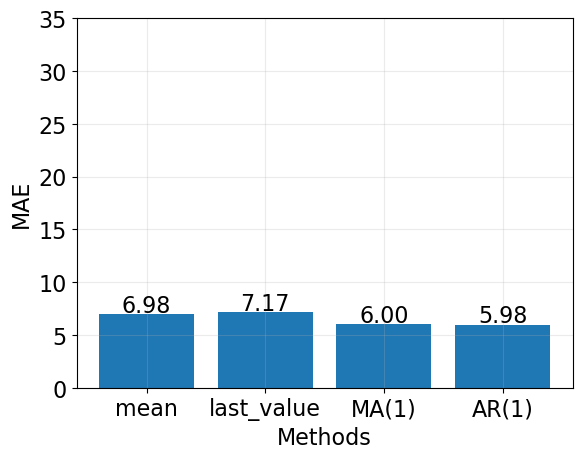

In [212]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)", "AR(1)"]
y_array = [mae_mean_undiff, mae_last_undiff, mae_MA_undiff, mae_AR_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAE")
ax.set_ylim([0, 35])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

MSE

In [213]:
mse_mean_undiff = mean_squared_error(df_test_H["rolling_7days"], df_test_H["pred_mean"])
mse_last_undiff = mean_squared_error(df_test_H["rolling_7days"], df_test_H["pred_last_value"])
mse_MA_undiff   = mean_squared_error(df_test_H["rolling_7days"], df_test_H["pred_MA"])
mse_AR_undiff   = mean_squared_error(df_test_H["rolling_7days"], df_test_H["pred_AR"])

print(f"MSE mean: {mse_mean_undiff}")
print(f"MSE last: {mse_last_undiff}")
print(f"MSE MA: {mse_MA_undiff}")
print(f"MSE AR: {mse_AR_undiff}")

MSE mean: 51.842230985878
MSE last: 56.8
MSE MA: 38.132185254942364
MSE AR: 37.89178960071472


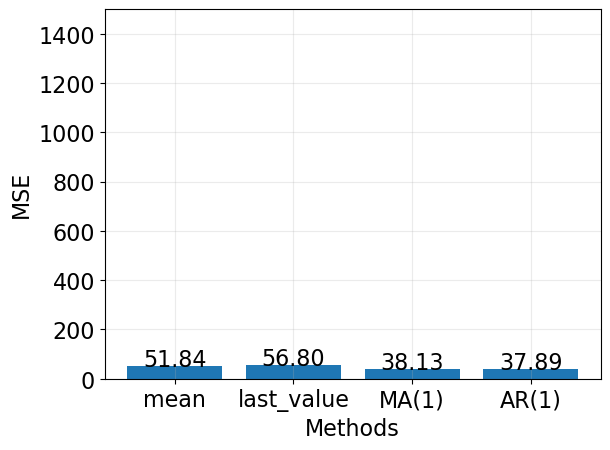

In [214]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)", "AR(1)"]
y_array = [mse_mean_undiff, mse_last_undiff, mse_MA_undiff, mse_AR_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim([0, 1500])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

RMSE

In [215]:
rmse_mean_undiff = np.sqrt(mse_mean_undiff)
rmse_last_undiff = np.sqrt(mse_last_undiff)
rmse_MA_undiff = np.sqrt(mse_MA_undiff)
rmse_AR_undiff = np.sqrt(mse_AR_undiff)

print(f"RMSE mean: {rmse_mean_undiff}")
print(f"RMSE last: {rmse_last_undiff}")
print(f"RMSE MA: {rmse_MA_undiff}")
print(f"RMSE AR: {rmse_AR_undiff}")

RMSE mean: 7.2001549279080095
RMSE last: 7.536577472566709
RMSE MA: 6.175126335140226
RMSE AR: 6.155630723225259


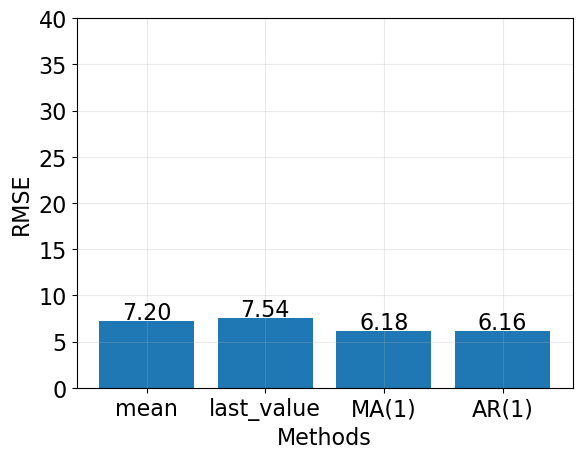

In [216]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)", "AR(1)"]
y_array = [rmse_mean_undiff, rmse_last_undiff, rmse_MA_undiff, rmse_AR_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("RMSE")
ax.set_ylim([0, 40])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

MAPE

In [217]:
mape_mean_undiff = mean_absolute_percentage_error(df_test_H["rolling_7days"], df_test_H["pred_mean"]) * 100
mape_last_undiff = mean_absolute_percentage_error(df_test_H["rolling_7days"], df_test_H["pred_last_value"]) * 100
mape_MA_undiff   = mean_absolute_percentage_error(df_test_H["rolling_7days"], df_test_H["pred_MA"]) * 100
mape_AR_undiff   = mean_absolute_percentage_error(df_test_H["rolling_7days"], df_test_H["pred_AR"]) * 100

print(f"MAPE mean: {mape_mean_undiff:.2f}%")
print(f"MAPE last: {mape_last_undiff:.2f}%")
print(f"MAPE MA: {mape_MA_undiff:.2f}%")
print(f"MAPE AR: {mape_AR_undiff:.2f}%")

MAPE mean: 92.51%
MAPE last: 93.25%
MAPE MA: 79.46%
MAPE AR: 79.21%


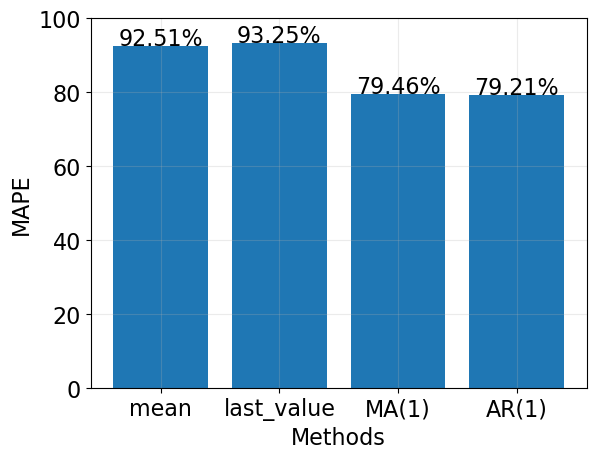

In [218]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)", "AR(1)"]
y_array = [mape_mean_undiff, mape_last_undiff, mape_MA_undiff, mape_AR_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAPE")
ax.set_ylim([0, 100])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}%", ha="center")

plt.show(fig)

MASE

In [219]:
naive = np.abs(np.diff(df_test_H["rolling_7days"])).mean()

mase_mean_undiff = mae_mean_undiff / naive
mase_last_undiff = mae_last_undiff / naive
mase_MA_undiff   = mae_MA_undiff / naive
mase_AR_undiff   = mae_AR_undiff / naive

print(f"MASE mean: {mase_mean_undiff}")
print(f"MASE last: {mase_last_undiff}")
print(f"MASE MA: {mase_MA_undiff}")
print(f"MASE AR: {mase_AR_undiff}")

MASE mean: 19.59690478523041
MASE last: 20.134920634920636
MASE MA: 16.858290204449144
MASE AR: 16.806467372241837


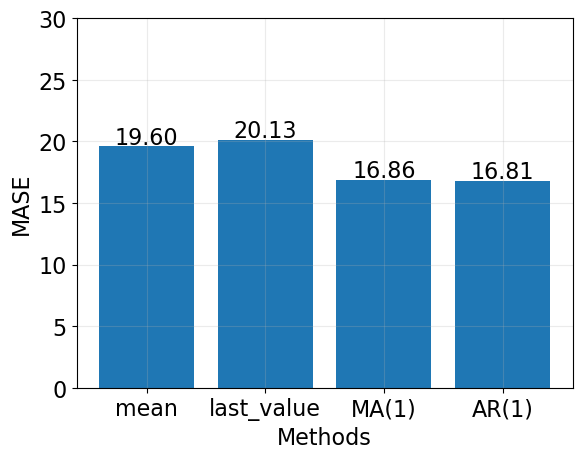

In [220]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)", "AR(1)"]
y_array = [mase_mean_undiff, mase_last_undiff, mase_MA_undiff, mase_AR_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MASE")
ax.set_ylim([0, 30])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

### Data Splitting ARIMA

In [221]:
split_idx = int(0.8 * len(df_H_count))
df_train_arima = df_H_count.iloc[:split_idx].copy()
df_test_arima = df_H_count.iloc[split_idx:].copy()

print(f"(len(df_train_arima), len(df_test_arima)): {len(df_train_arima), len(df_test_arima)}")

(len(df_train_arima), len(df_test_arima)): (240, 60)


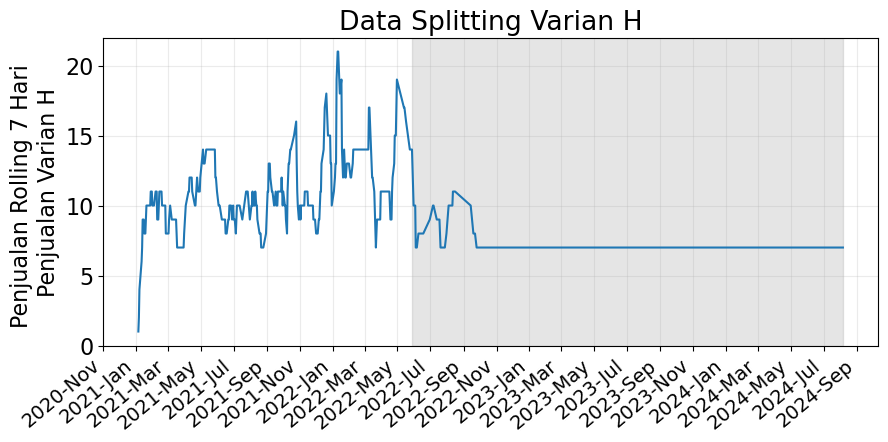

In [222]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df_H_count['Tgl. Mohon'], df_H_count["rolling_7days"])
ax.grid("on")
ax.set_ylabel("Penjualan Rolling 7 Hari \nPenjualan Varian H")
ax.set_title("Data Splitting Varian H")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

# add forecast area
ax.axvspan(df_test_arima['Tgl. Mohon'].iloc[0], df_test_arima['Tgl. Mohon'].iloc[-1], 
                color="#808080", alpha=0.2)

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
  label.set_size(14)
  label.set_horizontalalignment('right')

plt.show(fig)

### ARIMA (1,1,1)

In [223]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int, 
                    enforce_stationarity: bool=True, 
                    enforce_invertibility: bool=True) -> pd.DataFrame:

  result = []
  # warnings.filterwarnings("error")   # handling warnings as error
  warnings.resetwarnings()     # to reset warnings

  for order in notebook.tqdm(order_list):
    print(f"{(order[0], order[1])}")
    try:
      model = SARIMAX(endog, order=(order[0], d, order[1]), 
                      simple_differencing=False, 
                      enforce_invertibility=enforce_invertibility,
                      enforce_stationarity=enforce_stationarity).fit(disp=False)
    except:
      continue

    aic = model.aic
    result.append([order, aic])

  
  result_df = pd.DataFrame(result)
  # print(result_df.columns)
  result_df.columns = ["(p,q)", "AIC"]

  # Sort in ascending order, lower AIC is better
  result_df = result_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)

  return result_df

In [224]:
p_space = range(0, 4, 1)
q_space = range(0, 4, 1)
d = 1

order_list = list(itertls.product(p_space, q_space))
order_list

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3)]

In [225]:
result_df = optimize_ARIMA(df_train_arima["rolling_7days"], order_list, d,
                            enforce_invertibility=True,
                            enforce_stationarity=True)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

(0, 0)
(0, 1)
(0, 2)
(0, 3)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(2, 0)


c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1)
(2, 2)


c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 3)


c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 0)
(3, 1)
(3, 2)


c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\miniconda3\Lib\site-

(3, 3)


c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,"(p,q)",AIC
0,"(3, 2)",752.148341
1,"(3, 3)",754.138108
2,"(2, 2)",759.573878
3,"(2, 3)",766.105887
4,"(1, 2)",777.013752
5,"(1, 0)",778.816926
6,"(0, 0)",778.819662
7,"(0, 1)",778.942824
8,"(1, 1)",780.355219
9,"(2, 0)",780.536671


In [226]:
best_p, best_q = (3, 2)
print(f"best (p,q): {(best_p, best_q)}")

best (p,q): (3, 2)


In [227]:
model_arima_best = SARIMAX(df_train_arima["rolling_7days"], order=(best_p, d, best_q), 
                        simple_differencing=False)
model_arima_best_fit = model_arima_best.fit(disp=False)

c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


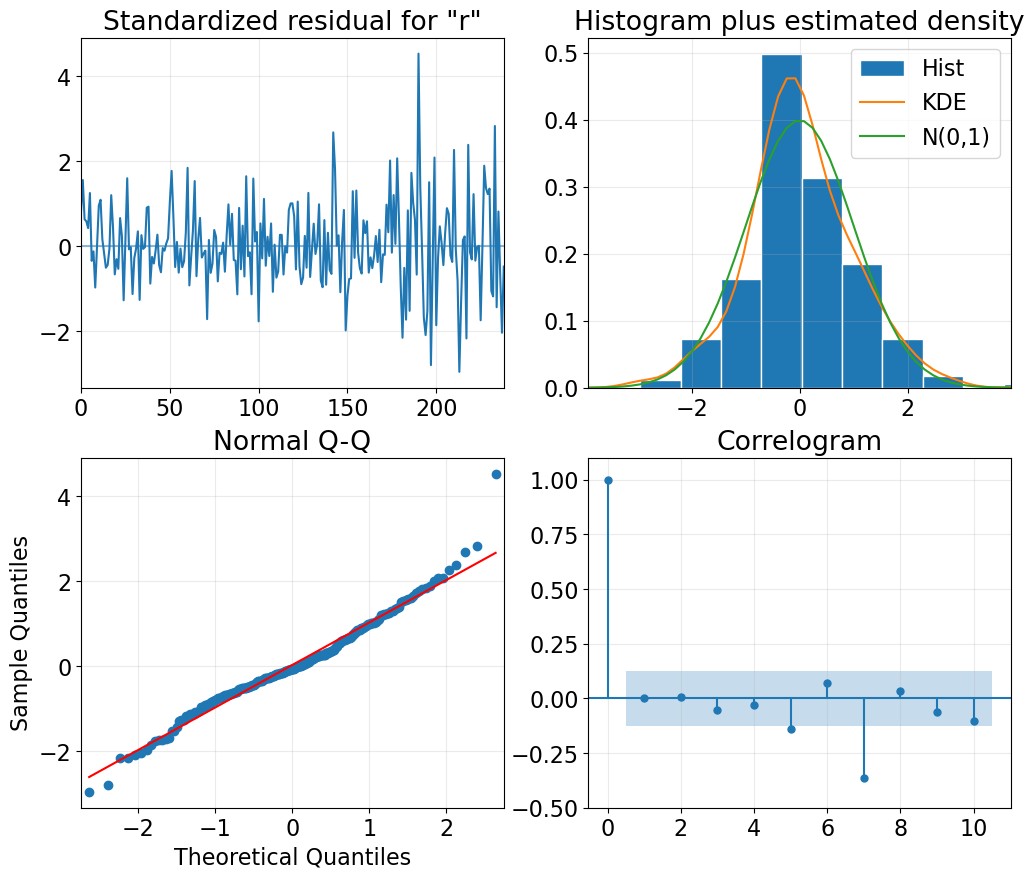

In [228]:
fig = model_arima_best_fit.plot_diagnostics(figsize=(12, 10))

# get all axes
axs = fig.get_axes()
for ax in axs:
  ax.grid("on")

# set y-lim for correlogram plot
axs[3].set_ylim([-0.5, 1.1])
plt.show(fig)

In [229]:
residuals = model_arima_best_fit.resid
ljung_box_test = acorr_ljungbox(residuals, np.arange(1, 11))
ljung_box_test

,lb_stat,lb_pvalue
1,0.008093,0.928317
2,0.057234,0.971789
3,0.702203,0.872686
4,0.858177,0.930483
5,5.487534,0.359315
6,6.889550,0.331183
7,39.390754,0.000002
8,39.704638,0.000004
9,40.744204,0.000006
10,43.280982,0.000004


In [230]:
df_test_pred_arima = df_test_arima.copy()

TRAIN_LEN = len(df_train_arima)
HORIZON = len(df_test_arima)

pred_mean = np.ones(HORIZON)*np.mean(df_train_arima["rolling_7days"])
pred_naive_seasonal = df_train_arima["rolling_7days"].iloc[-HORIZON:].values
pred_arima = model_arima_best_fit.get_prediction(
  TRAIN_LEN, TRAIN_LEN + HORIZON - 1).predicted_mean

df_test_pred_arima["pred_mean"] = pred_mean
df_test_pred_arima["pred_naive_seasonal"] = pred_naive_seasonal
df_test_pred_arima["pred_arima"] = pred_arima

df_test_pred_arima.head()

,Tgl. Mohon,count,cumulative_sum,rolling_7days,pred_mean,pred_naive_seasonal,pred_arima
240,2022-05-28,1,381,14.0,10.941667,18.0,14.038042
241,2022-05-31,1,382,10.0,10.941667,17.0,13.199911
242,2022-06-03,1,383,10.0,10.941667,15.0,12.143400
243,2022-06-04,1,384,7.0,10.941667,15.0,11.624849
244,2022-06-06,1,385,7.0,10.941667,13.0,11.809423


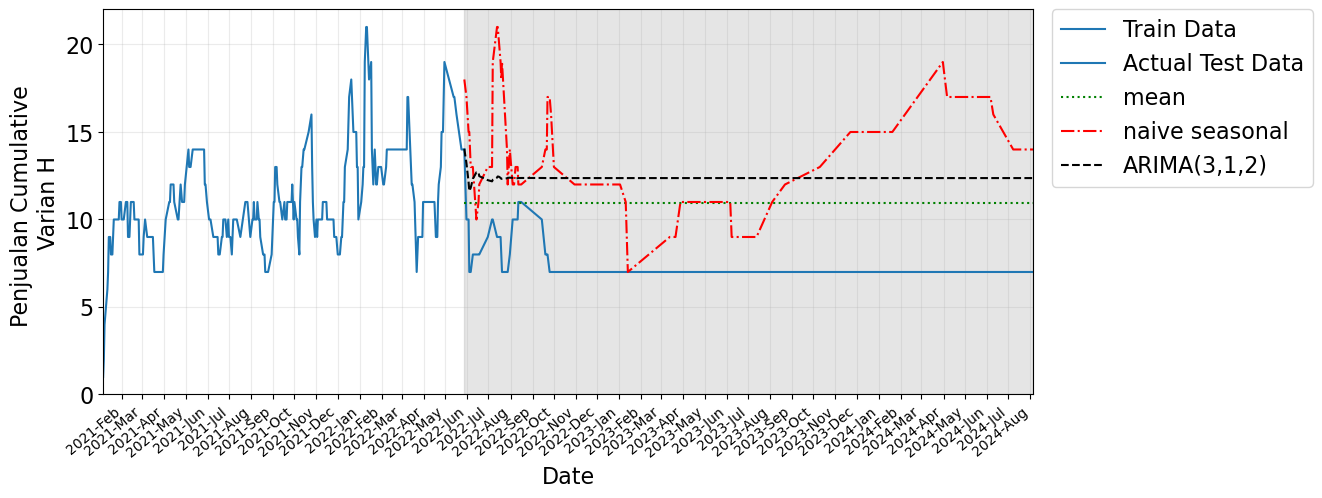

In [231]:
df_train_arima_extended = pd.concat([df_train_arima, df_test_arima.iloc[:1]], ignore_index=True)

start_idx = 0  # for better visualization
xlim = [df_train_arima_extended["Tgl. Mohon"].iloc[start_idx], df_test_arima["Tgl. Mohon"].iloc[-1]]

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df_train_arima_extended["Tgl. Mohon"], df_train_arima_extended["rolling_7days"], label="Train Data")
ax.plot(df_test_arima["Tgl. Mohon"], df_test_arima["rolling_7days"], color="tab:blue", label="Actual Test Data")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

# ax.set_ylim([-0.5, 17])
ax.set_xlim(xlim)
ax.grid("on")
ax.set_xlabel("Date")
ax.set_ylabel("Penjualan Cumulative \nVarian H")

# -- prediction
ax.plot(df_test_pred_arima["Tgl. Mohon"], df_test_pred_arima["pred_mean"], "g:", label="mean")
ax.plot(df_test_pred_arima["Tgl. Mohon"], df_test_pred_arima["pred_naive_seasonal"], "r-.", label="naive seasonal")
ax.plot(df_test_pred_arima["Tgl. Mohon"], df_test_pred_arima["pred_arima"], "k--", 
        label=f"ARIMA({best_p},{d},{best_q})")

# add forecast area
ax.axvspan(df_test_arima['Tgl. Mohon'].iloc[0], df_test_arima['Tgl. Mohon'].iloc[-1], 
                color="#808080", alpha=0.2)

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
  label.set_size(10)
  label.set_horizontalalignment('right')

# -- add legend in the second row
ax.legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

plt.show(fig)

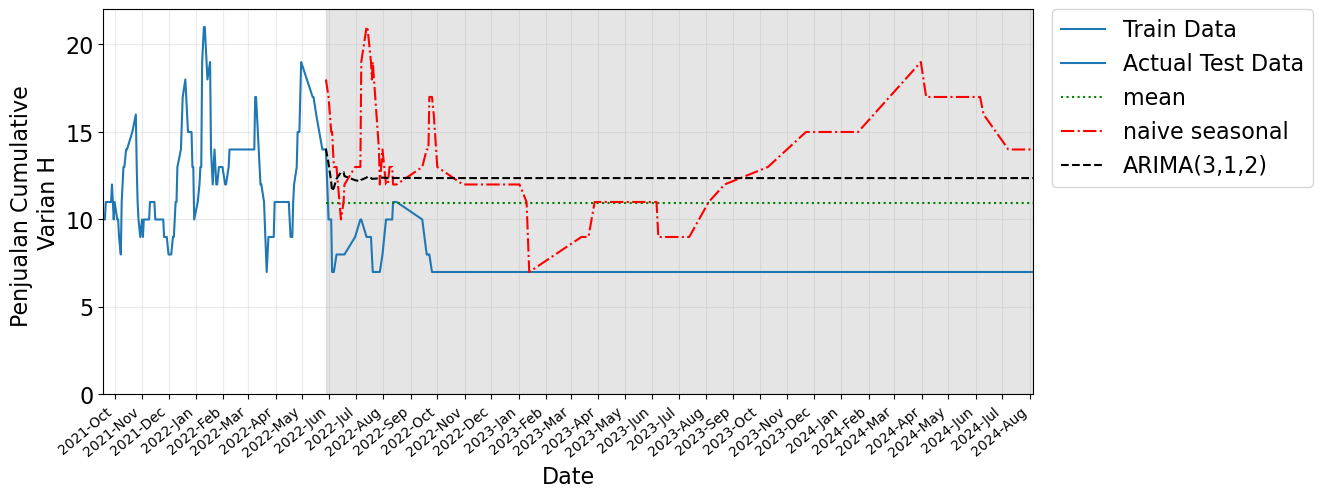

In [232]:
df_train_arima_extended = pd.concat([df_train_arima, df_test_arima.iloc[:1]], ignore_index=True)

start_idx = 130  # for better visualization
xlim = [df_train_arima_extended["Tgl. Mohon"].iloc[start_idx], df_test_arima["Tgl. Mohon"].iloc[-1]]

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df_train_arima_extended["Tgl. Mohon"], df_train_arima_extended["rolling_7days"], label="Train Data")
ax.plot(df_test_arima["Tgl. Mohon"], df_test_arima["rolling_7days"], color="tab:blue", label="Actual Test Data")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

# ax.set_ylim([-0.5, 17])
ax.set_xlim(xlim)
ax.grid("on")
ax.set_xlabel("Date")
ax.set_ylabel("Penjualan Cumulative \nVarian H")

# -- prediction
ax.plot(df_test_pred_arima["Tgl. Mohon"], df_test_pred_arima["pred_mean"], "g:", label="mean")
ax.plot(df_test_pred_arima["Tgl. Mohon"], df_test_pred_arima["pred_naive_seasonal"], "r-.", label="naive seasonal")
ax.plot(df_test_pred_arima["Tgl. Mohon"], df_test_pred_arima["pred_arima"], "k--", 
        label=f"ARIMA({best_p},{d},{best_q})")

# add forecast area
ax.axvspan(df_test_arima['Tgl. Mohon'].iloc[0], df_test_arima['Tgl. Mohon'].iloc[-1], 
                color="#808080", alpha=0.2)

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
  label.set_size(10)
  label.set_horizontalalignment('right')

# -- add legend in the second row
ax.legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

plt.show(fig)

### Evaluasi ARIMA (1,1,1)

MAE

In [233]:
mae_mean           = mean_absolute_error(df_test_pred_arima["rolling_7days"], df_test_pred_arima["pred_mean"])
mae_naive_seasonal = mean_absolute_error(df_test_pred_arima["rolling_7days"], df_test_pred_arima["pred_naive_seasonal"])
mae_arima          = mean_absolute_error(df_test_pred_arima["rolling_7days"], df_test_pred_arima["pred_arima"])

print(f"MAE mean: {mae_mean}")
print(f"MAE naive seasonal: {mae_naive_seasonal}")
print(f"MAE ARIMA: {mae_arima}")

MAE mean: 3.014166666666666
MAE naive seasonal: 5.766666666666667
MAE ARIMA: 4.357061137131935


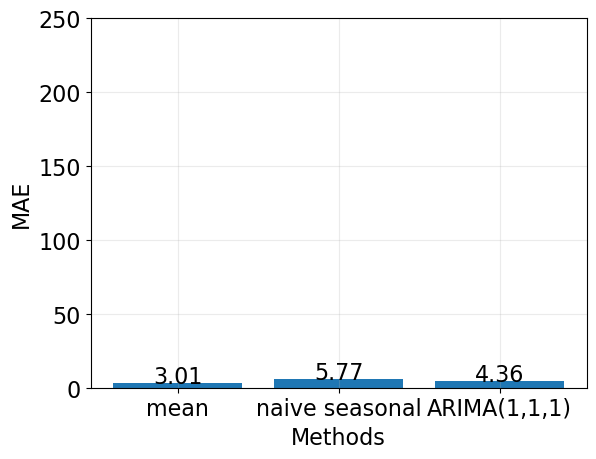

In [234]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(1,1,1)"]
y_array = [mae_mean, mae_naive_seasonal, mae_arima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAE")
ax.set_ylim([0, 250])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.1, s=f"{val:.2f}", ha="center")

plt.show(fig)

MSE

In [235]:
mse_mean           = mean_squared_error(df_test_pred_arima["rolling_7days"], df_test_pred_arima["pred_mean"])
mse_naive_seasonal = mean_squared_error(df_test_pred_arima["rolling_7days"], df_test_pred_arima["pred_naive_seasonal"])
mse_arima          = mean_squared_error(df_test_pred_arima["rolling_7days"], df_test_pred_arima["pred_arima"])

print(f"MSE mean: {mse_mean}")
print(f"MSE naive seasonal: {mse_naive_seasonal}")
print(f"MSE ARIMA: {mse_arima}")

MSE mean: 10.590624999999994
MSE naive seasonal: 43.3
MSE ARIMA: 20.79261505520518


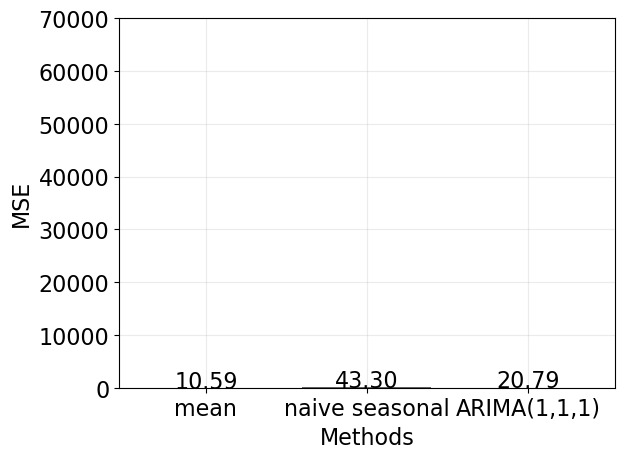

In [236]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(1,1,1)"]
y_array = [mse_mean, mse_naive_seasonal, mse_arima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim([0, 70000])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.1, s=f"{val:.2f}", ha="center")

plt.show(fig)

RMSE

In [237]:
rmse_mean           = np.sqrt(mse_mean)
rmse_naive_seasonal = np.sqrt(mse_naive_seasonal)
rmse_arima          = np.sqrt(mse_arima)

print(f"RMSE mean: {rmse_mean}")
print(f"RMSE naive seasonal: {rmse_naive_seasonal}")
print(f"RMSE ARIMA: {rmse_arima}")

RMSE mean: 3.2543240465571333
RMSE naive seasonal: 6.58027355054484
RMSE ARIMA: 4.559892000388296


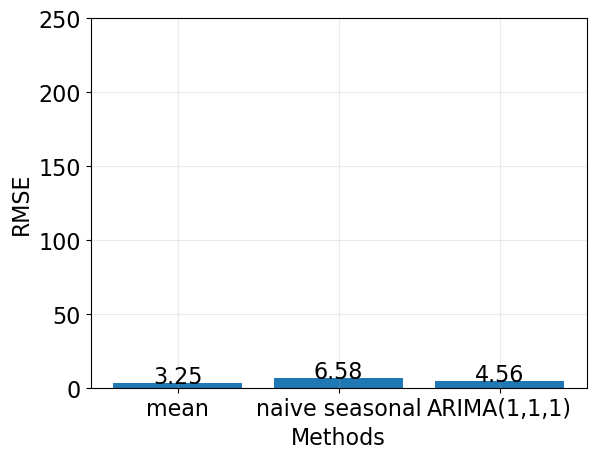

In [238]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(1,1,1)"]
y_array = [rmse_mean, rmse_naive_seasonal, rmse_arima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("RMSE")
ax.set_ylim([0, 250])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.1, s=f"{val:.2f}", ha="center")

plt.show(fig)

MAPE

In [239]:
mape_mean           = np.mean(np.abs((df_test_pred_arima["rolling_7days"] - df_test_pred_arima["pred_mean"]) / df_test_pred_arima["rolling_7days"])) * 100
mape_naive_seasonal = np.mean(np.abs((df_test_pred_arima["rolling_7days"] - df_test_pred_arima["pred_naive_seasonal"]) / df_test_pred_arima["rolling_7days"])) * 100
mape_arima          = np.mean(np.abs((df_test_pred_arima["rolling_7days"] - df_test_pred_arima["pred_arima"]) / df_test_pred_arima["rolling_7days"])) * 100

print(f"MAPE mean: {mape_mean:.2f}%")
print(f"MAPE naive seasonal: {mape_naive_seasonal:.2f}%")
print(f"MAPE ARIMA: {mape_arima:.2f}%")

MAPE mean: 40.69%
MAPE naive seasonal: 74.80%
MAPE ARIMA: 58.24%


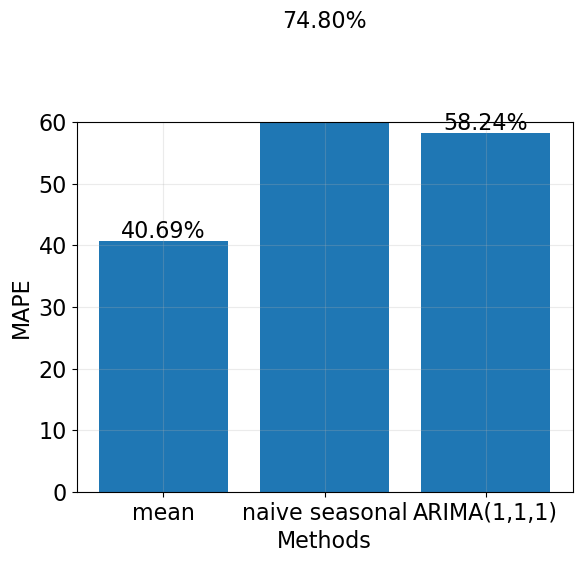

In [240]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(1,1,1)"]
y_array = [mape_mean, mape_naive_seasonal, mape_arima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAPE")
ax.set_ylim([0, 60])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.5, s=f"{val:.2f}%", ha="center")

plt.show(fig)

In [241]:
naive = np.abs(np.diff(df_test_pred_arima["rolling_7days"])).mean()

mase_mean           = mae_mean_undiff / naive
mase_naive_seasonal = mae_naive_seasonal / naive
mase_arima          = mae_arima / naive

print(f"MASE mean: {mase_mean}")
print(f"MASE naive seasonal: {mase_naive_seasonal}")
print(f"MASE ARIMA: {mase_arima}")

MASE mean: 19.59690478523041
MASE naive seasonal: 16.201587301587303
MASE ARIMA: 12.241267004323056


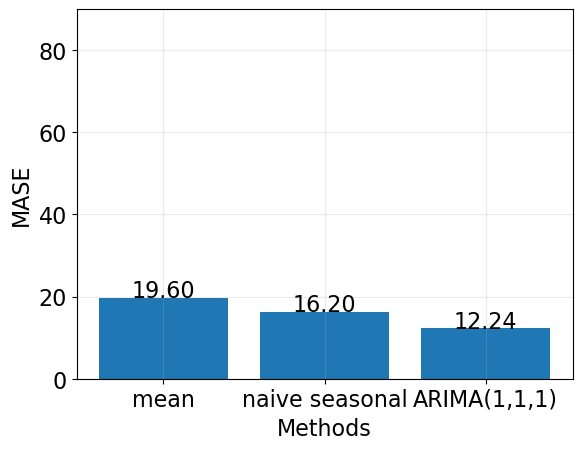

In [242]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(1,1,1)"]
y_array = [mase_mean, mase_naive_seasonal, mase_arima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MASE")
ax.set_ylim([0, 90])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)